## Notebook Configuration && Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

from storesales.utils import save_submission
from storesales.advanced_predictor import AdvancedPredictor
from storesales.light_gbm.fit_evaluate.evaluate_models import evaluate
from storesales.light_gbm.utils import (
    make_submission_predictions,
    print_models_params,
    plot_feature_importance,
    load_family_lightgbm_and_dataset,
)
from storesales.constants import (
    TEST_DATE_RANGE,
    MIDDLE_TEST_DATE,
    EXTERNAL_TRAIN_PATH,
    EXTERNAL_TEST_PATH,
)

## Load && Preprocess Data

In [3]:
train_df = pd.read_csv(EXTERNAL_TRAIN_PATH, parse_dates=["date"])
test_df = pd.read_csv(EXTERNAL_TEST_PATH, parse_dates=["date"])

In [4]:
baseline_train_df = train_df.rename(columns={"date": "ds", "sales": "y"})
baseline_test_df = test_df.rename(columns={"date": "ds"})

### Load Baseline and LightGBM

In [5]:
baseline_model_file_paths = [
    "daily_predictor.pkl",
    "day_of_week_predictor.pkl",
    "weighted_day_predictor.pkl",
]
baseline_model_names = ["daily", "day_of_week", "weighted_day"]

In [6]:
# 'BOOKS'

families_for_lightgbm = [
    "EGGS",
    "LIQUOR,WINE,BEER",
    "MEATS",
    "POULTRY",
    # ---
    "CELEBRATION",
    "AUTOMOTIVE",
    "BEAUTY",
    "BEVERAGES",
    "BREAD/BAKERY",
    "CLEANING",
    "DAIRY",
    "DELI",
    "FROZEN FOODS",
    "GROCERY I",
    # ---
    "GROCERY II",
    "HARDWARE",
    "HOME AND KITCHEN I",
    "HOME AND KITCHEN II",
    "HOME APPLIANCES",
    "HOME CARE",
    "LADIESWEAR",
    "LAWN AND GARDEN",
    "LINGERIE",
    # ---
    "PERSONAL CARE",
    "PET SUPPLIES",
    "PLAYERS AND ELECTRONICS",
    "PREPARED FOODS",
    "PRODUCE",
    "SCHOOL AND OFFICE SUPPLIES",
    "SEAFOOD",
    "BABY CARE",
    "MAGAZINES",
]
dir_suffixes = ["_default_model", "", "", ""] + [
    "_default_model_mean_and_std_features"
] * 28

In [7]:
lightgbm_models = {}
family_datasets = {}

for family, suffix in zip(families_for_lightgbm, dir_suffixes):
    model, family_dataset = load_family_lightgbm_and_dataset(family, dir_suffix=suffix)
    lightgbm_models[family] = model
    family_datasets[family] = family_dataset

## Evaluate && Make Submission Prediction

In [8]:
eval_family_losses = evaluate(
    dataset=family_datasets,
    evaluate_range=TEST_DATE_RANGE,
    models=lightgbm_models,
    stride=1,
    n_jobs=4,
)

100%|██████████| 32/32 [05:14<00:00,  9.84s/it]


In [9]:
lightgbm_prediction_df = make_submission_predictions(
    family_datasets=family_datasets, models=lightgbm_models
)

100%|██████████| 32/32 [00:14<00:00,  2.16it/s]


In [ ]:
advanced_predictor = AdvancedPredictor(
    loss_split_date_str=MIDDLE_TEST_DATE,
    baseline_model_names=baseline_model_names,
    baseline_model_file_paths=baseline_model_file_paths,
    baseline_train_df=baseline_train_df,
    baseline_test_df=baseline_test_df,
    lightgbm_model_loss_df=eval_family_losses,
    lightgbm_model_prediction_df=lightgbm_prediction_df.reset_index(),
)

## Plot Result

In [91]:
test_period = True

In [132]:
import numpy as np

arr = np.array([1, 2, 1, 2])
np.std
(arr - arr.mean()) / arr.std()

array([-1.,  1., -1.,  1.])

In [133]:
arr = np.array([10, 20, 10, 20])

(arr - arr.mean()) / arr.std()

array([-1.,  1., -1.,  1.])

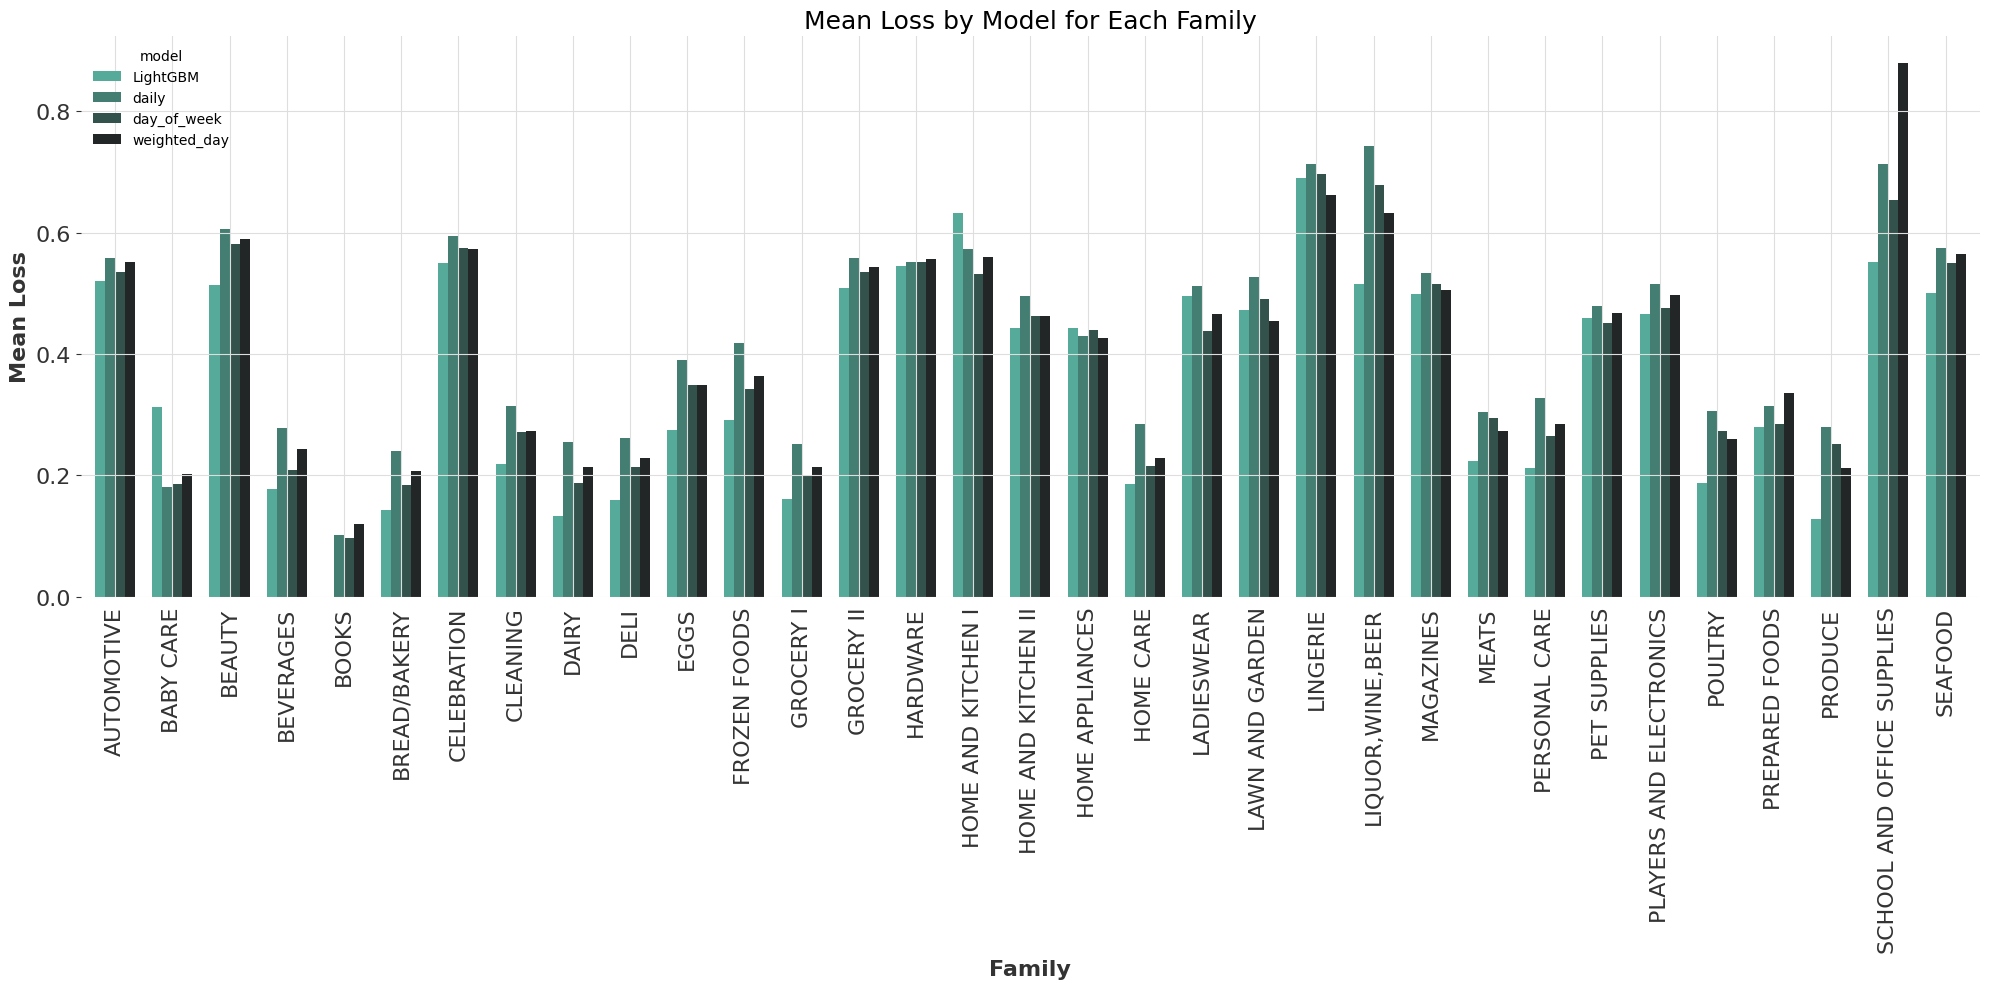

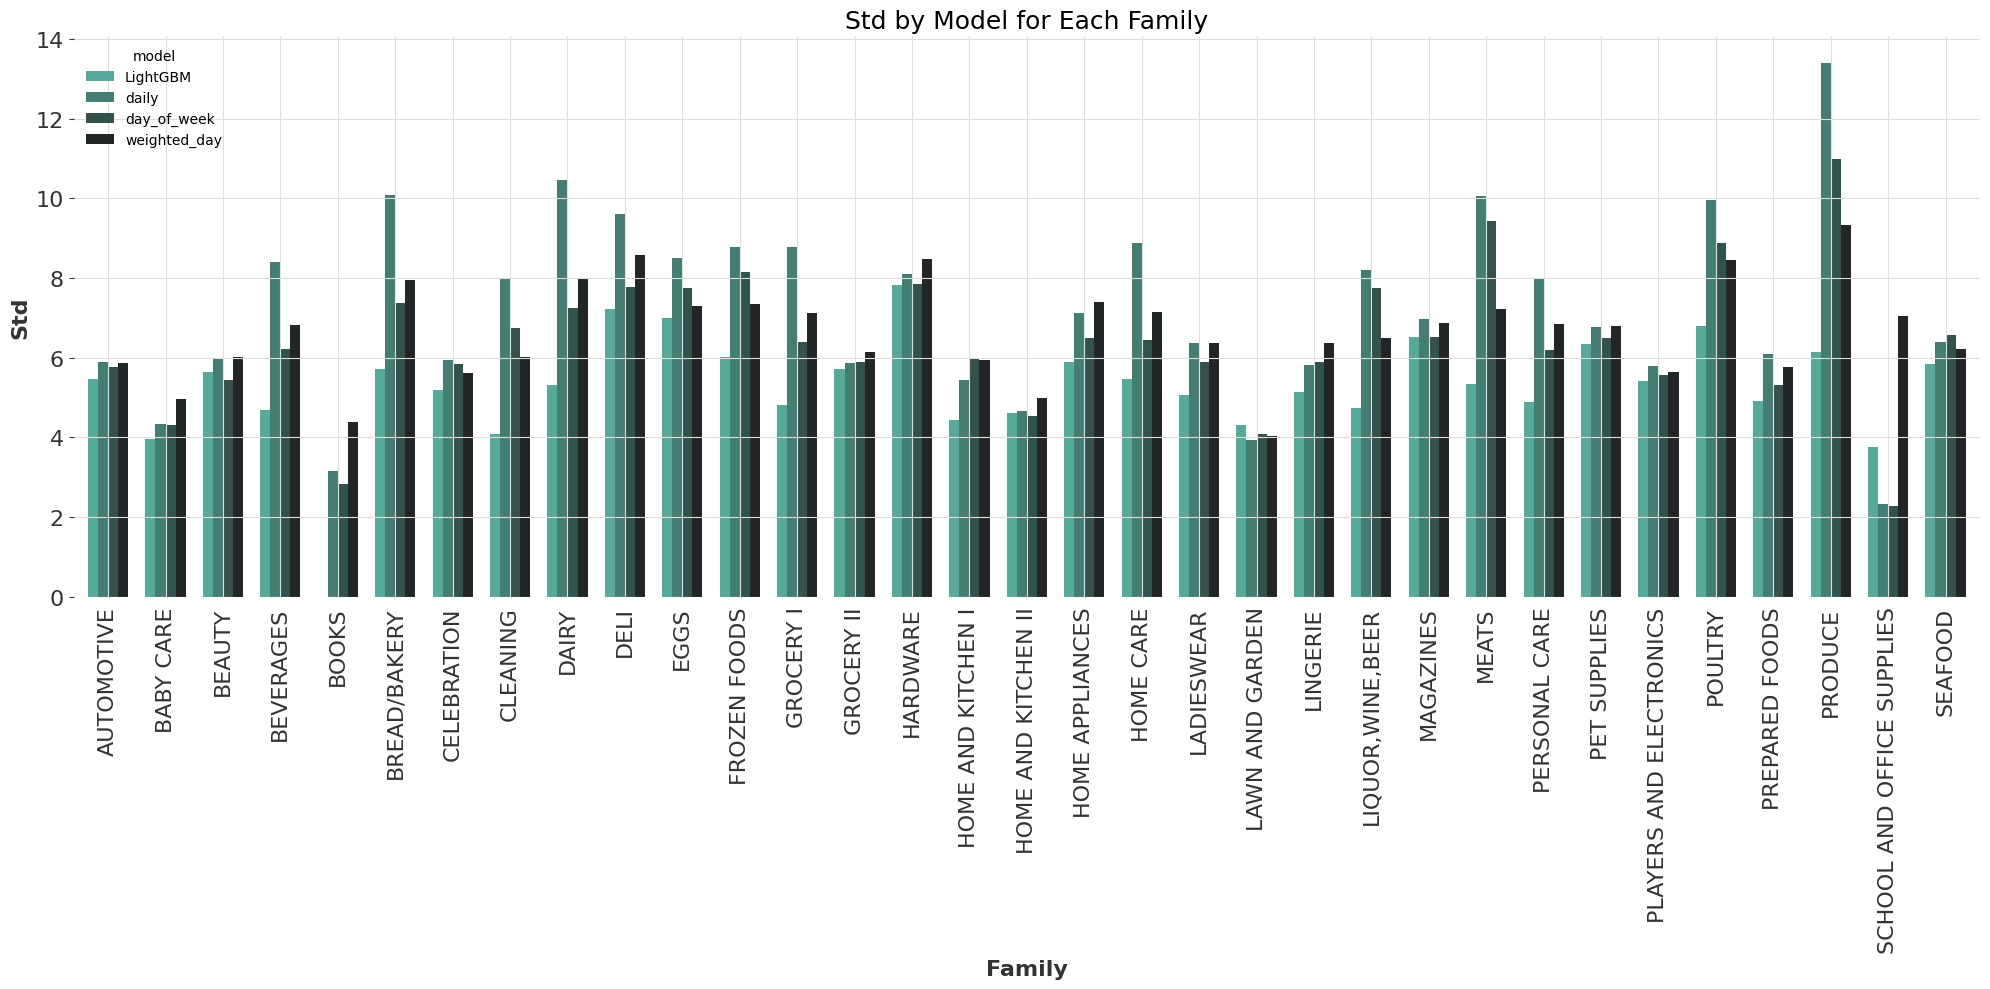

In [137]:
advanced_predictor.make_overall_family_loss_plot(test_loss=False)

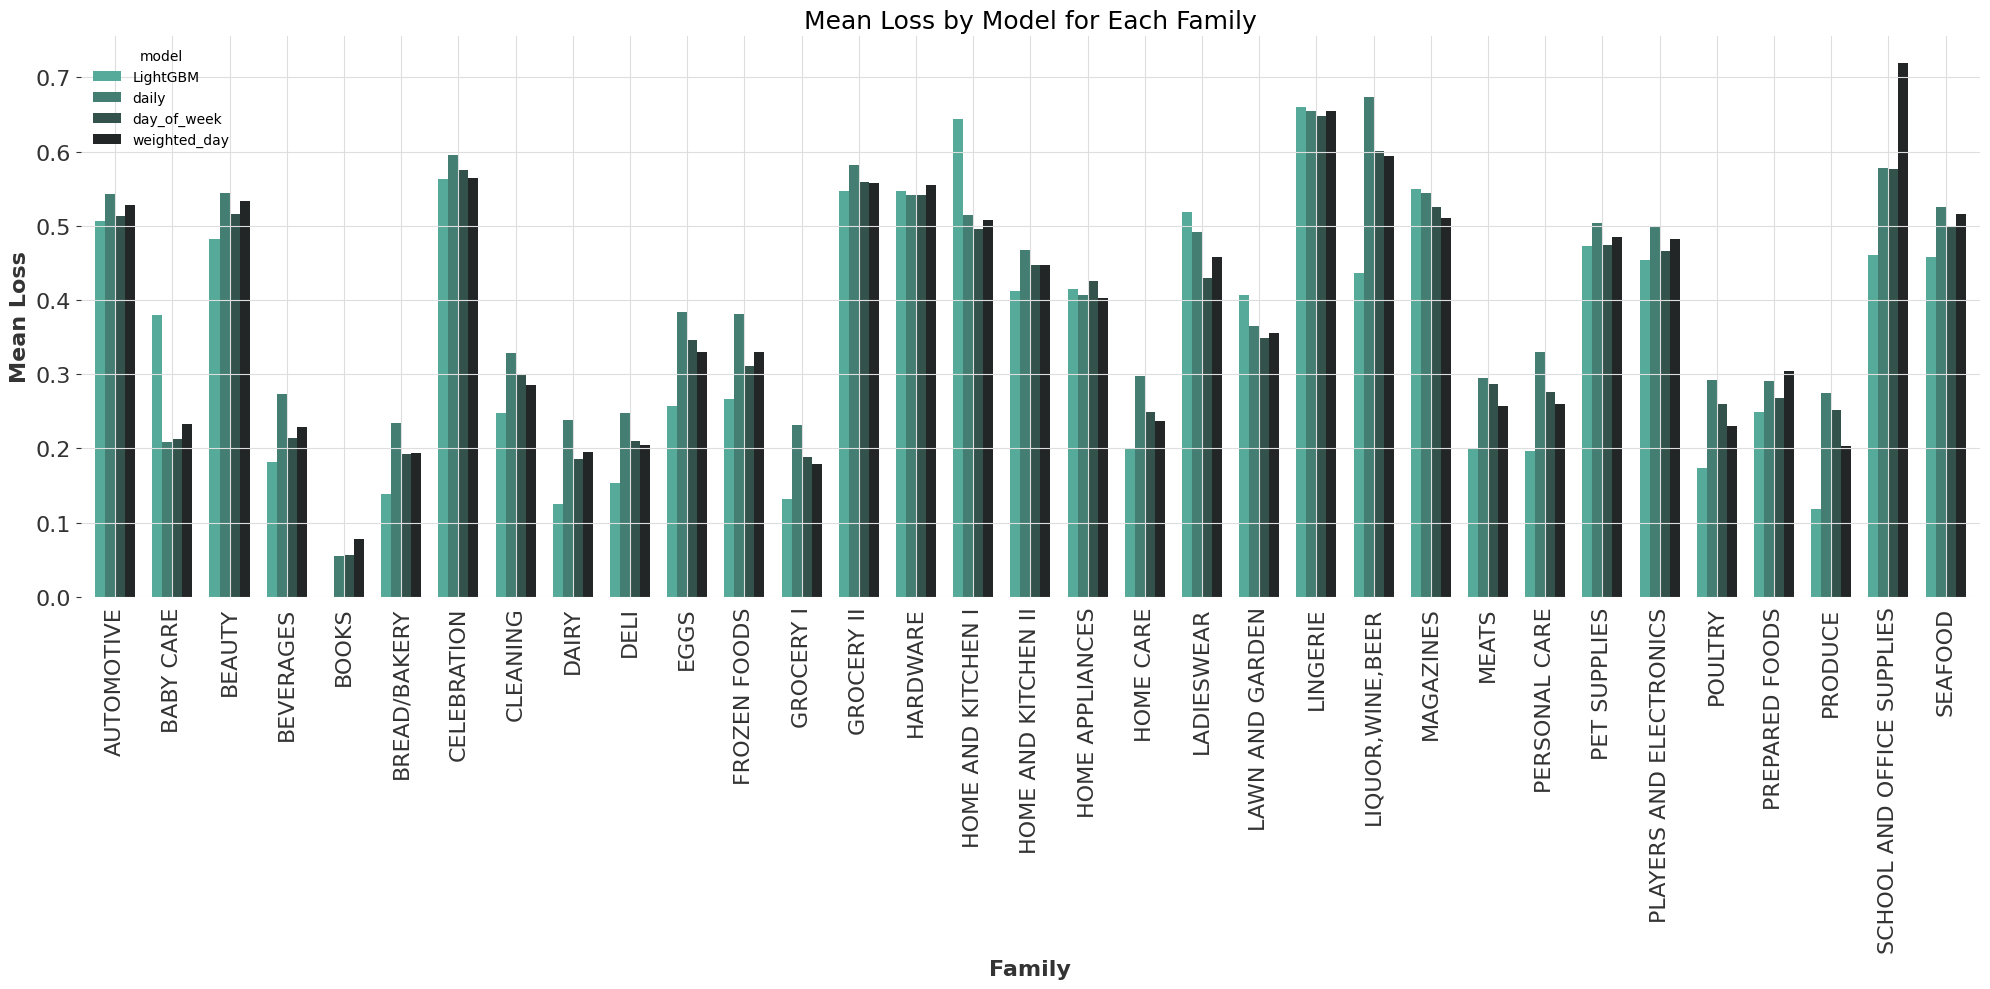

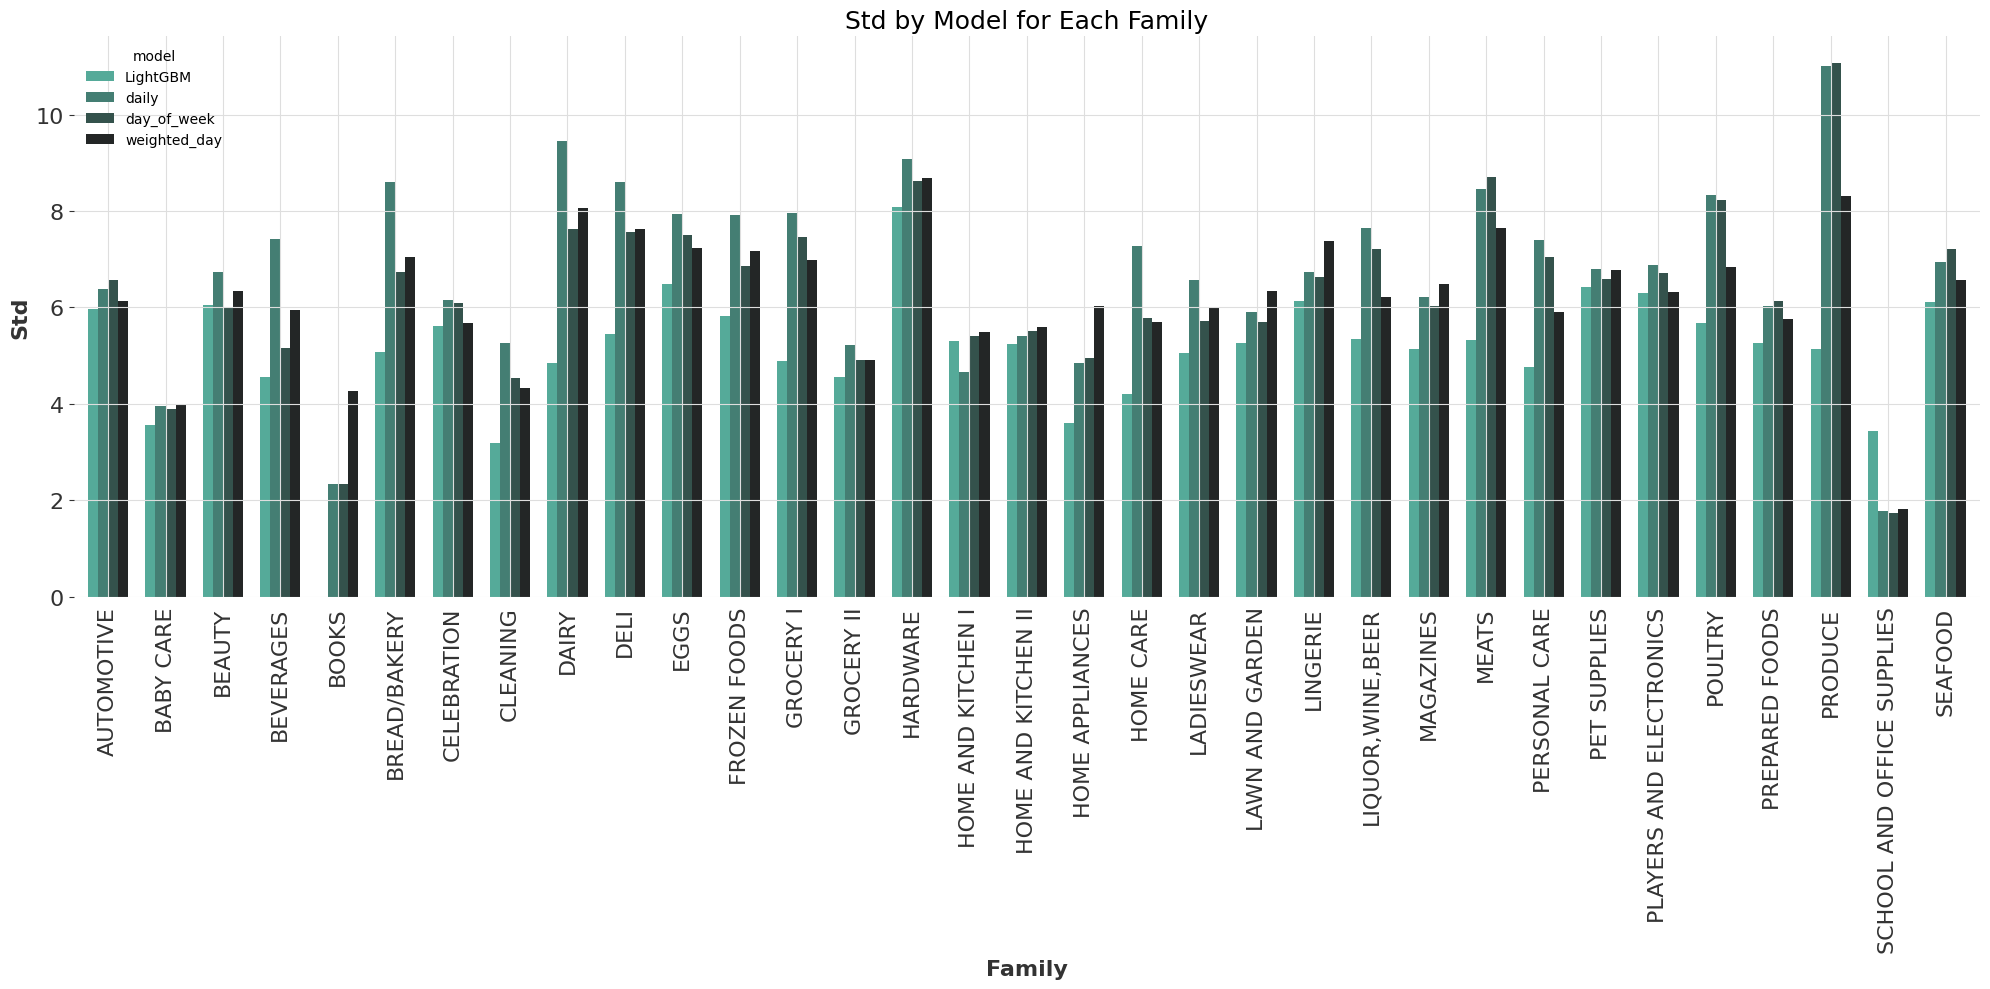

In [138]:
advanced_predictor.make_overall_family_loss_plot(test_loss=True)

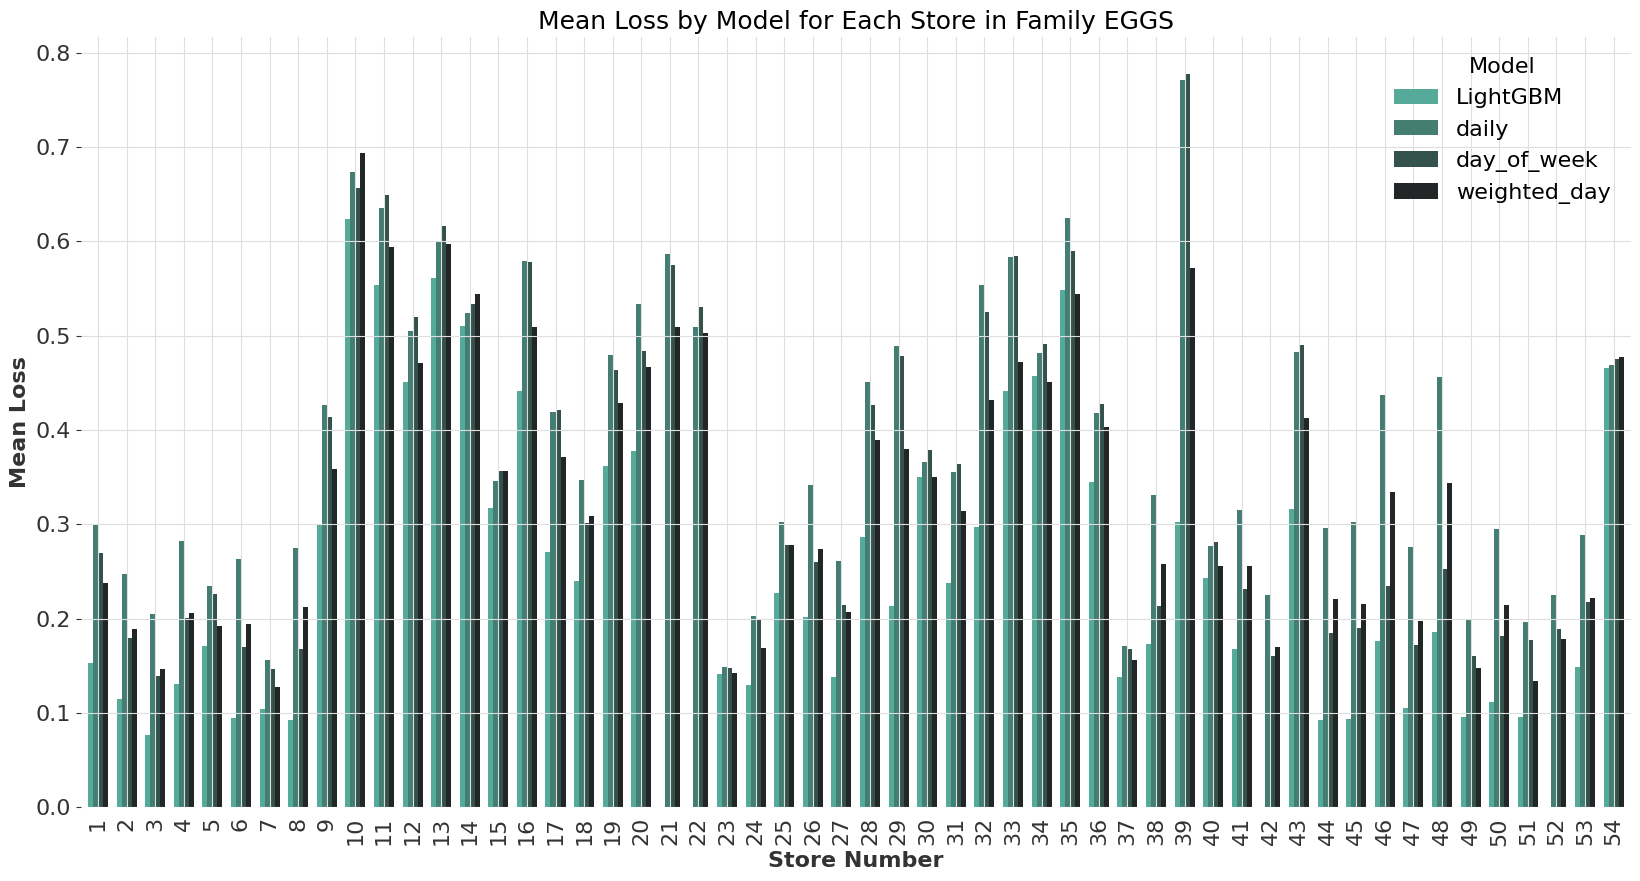

<Figure size 640x480 with 0 Axes>

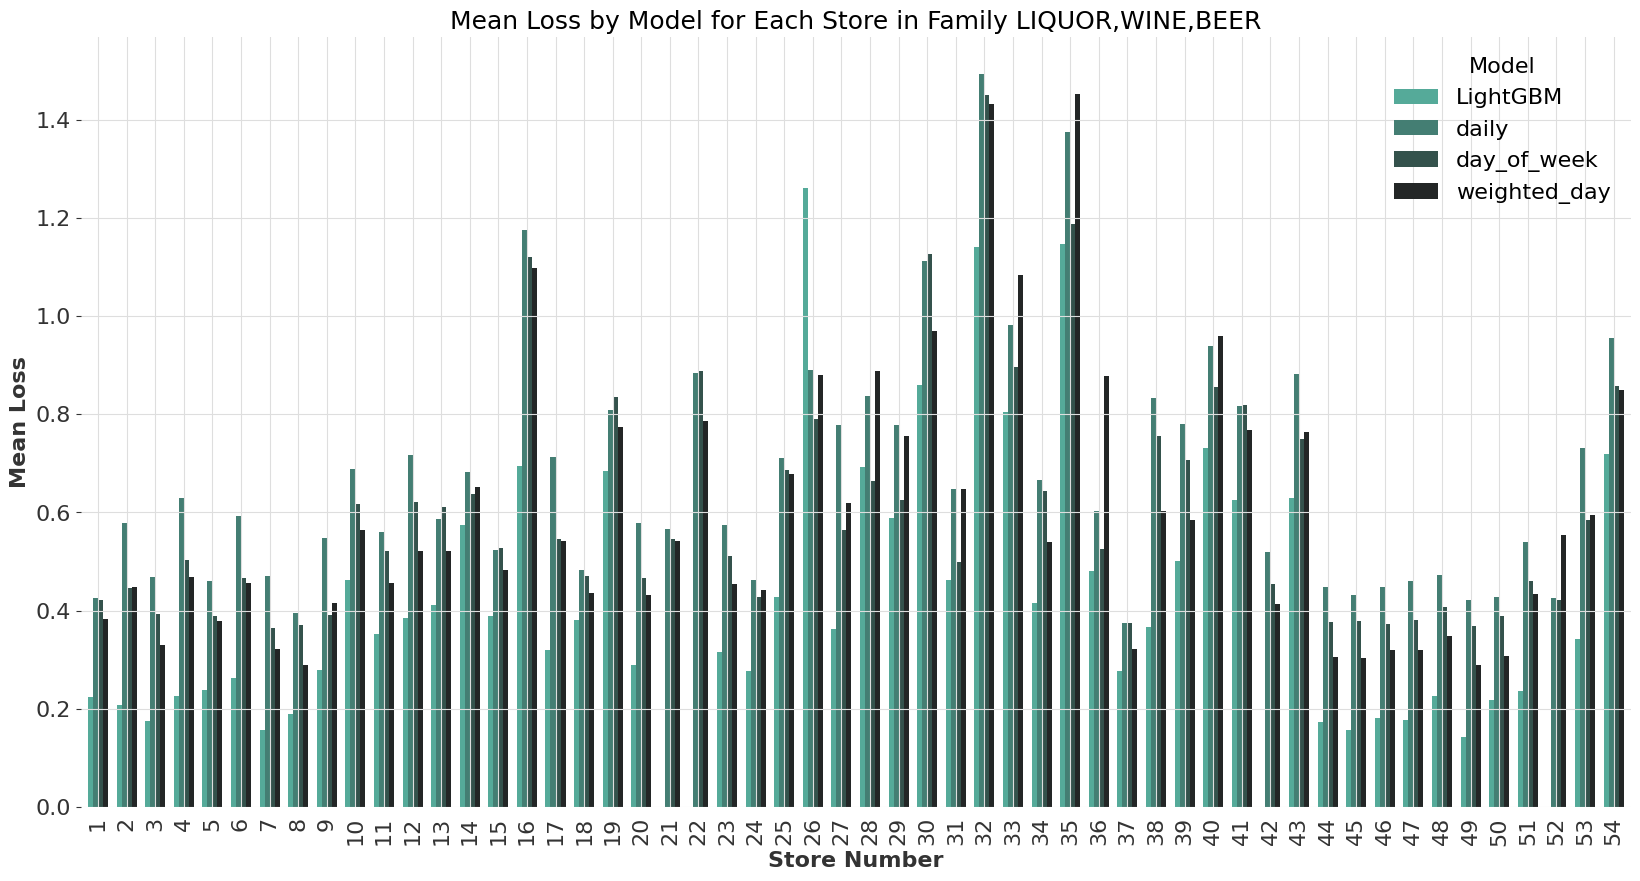

<Figure size 640x480 with 0 Axes>

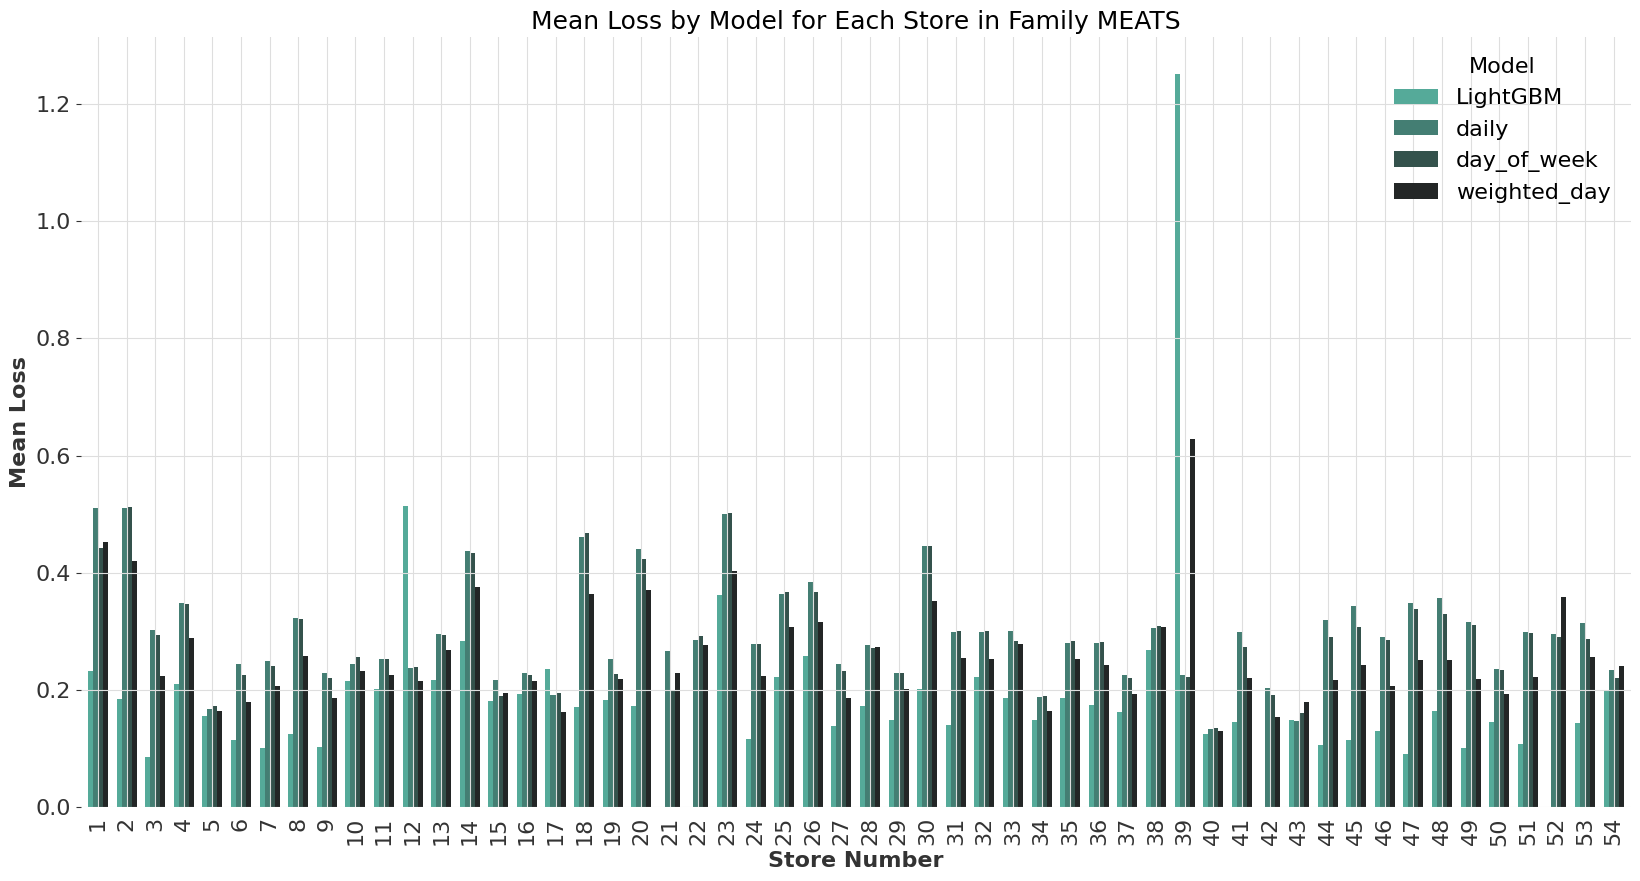

<Figure size 640x480 with 0 Axes>

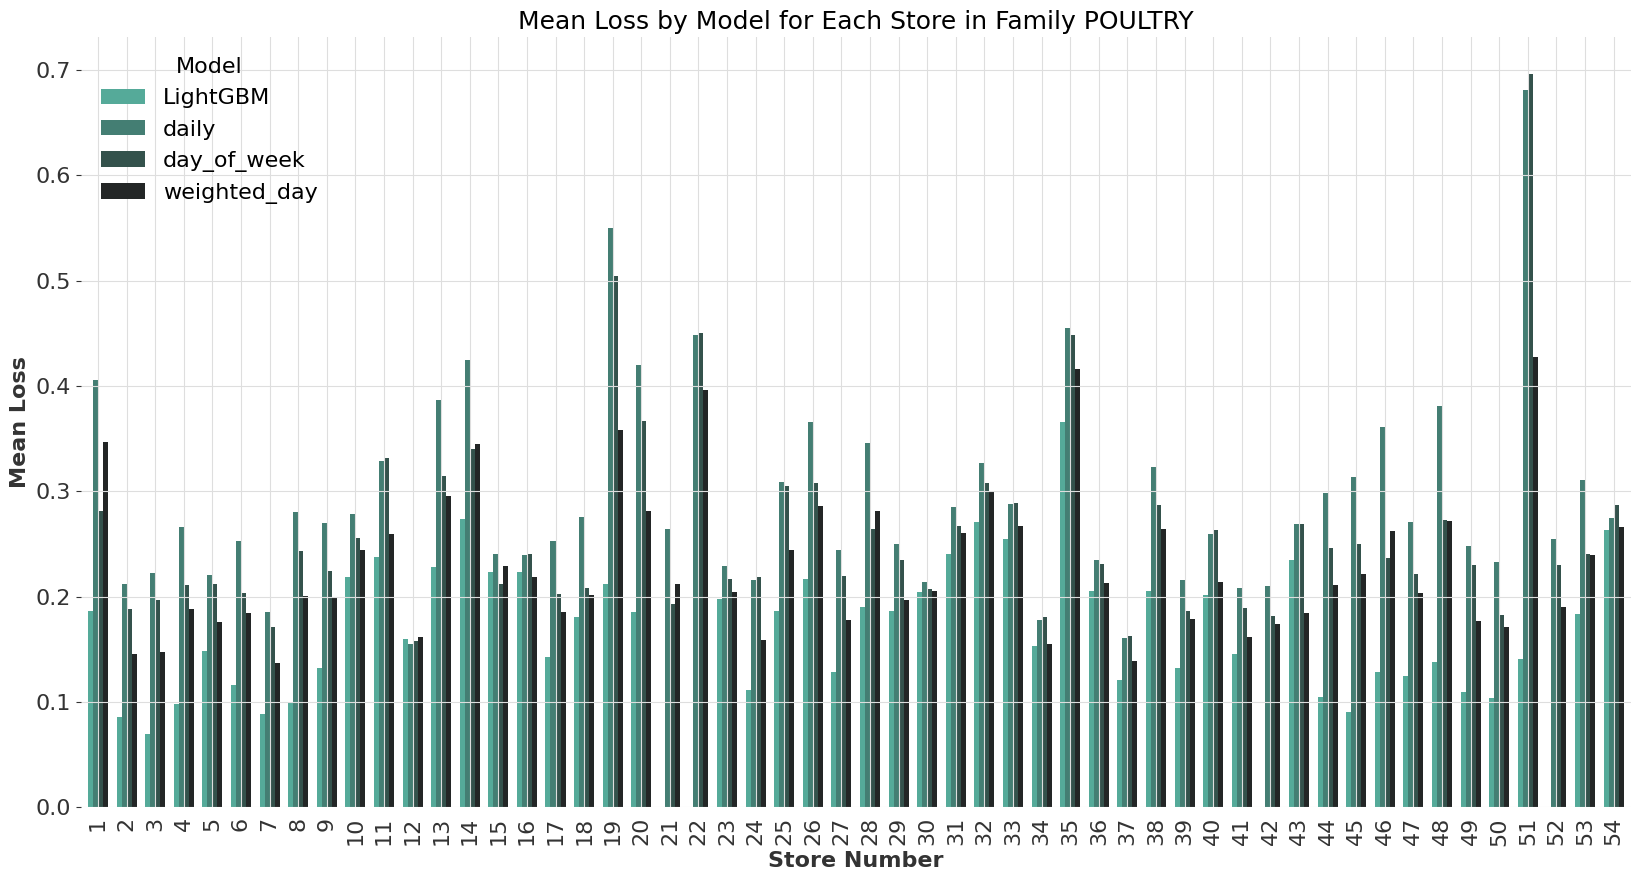

<Figure size 640x480 with 0 Axes>

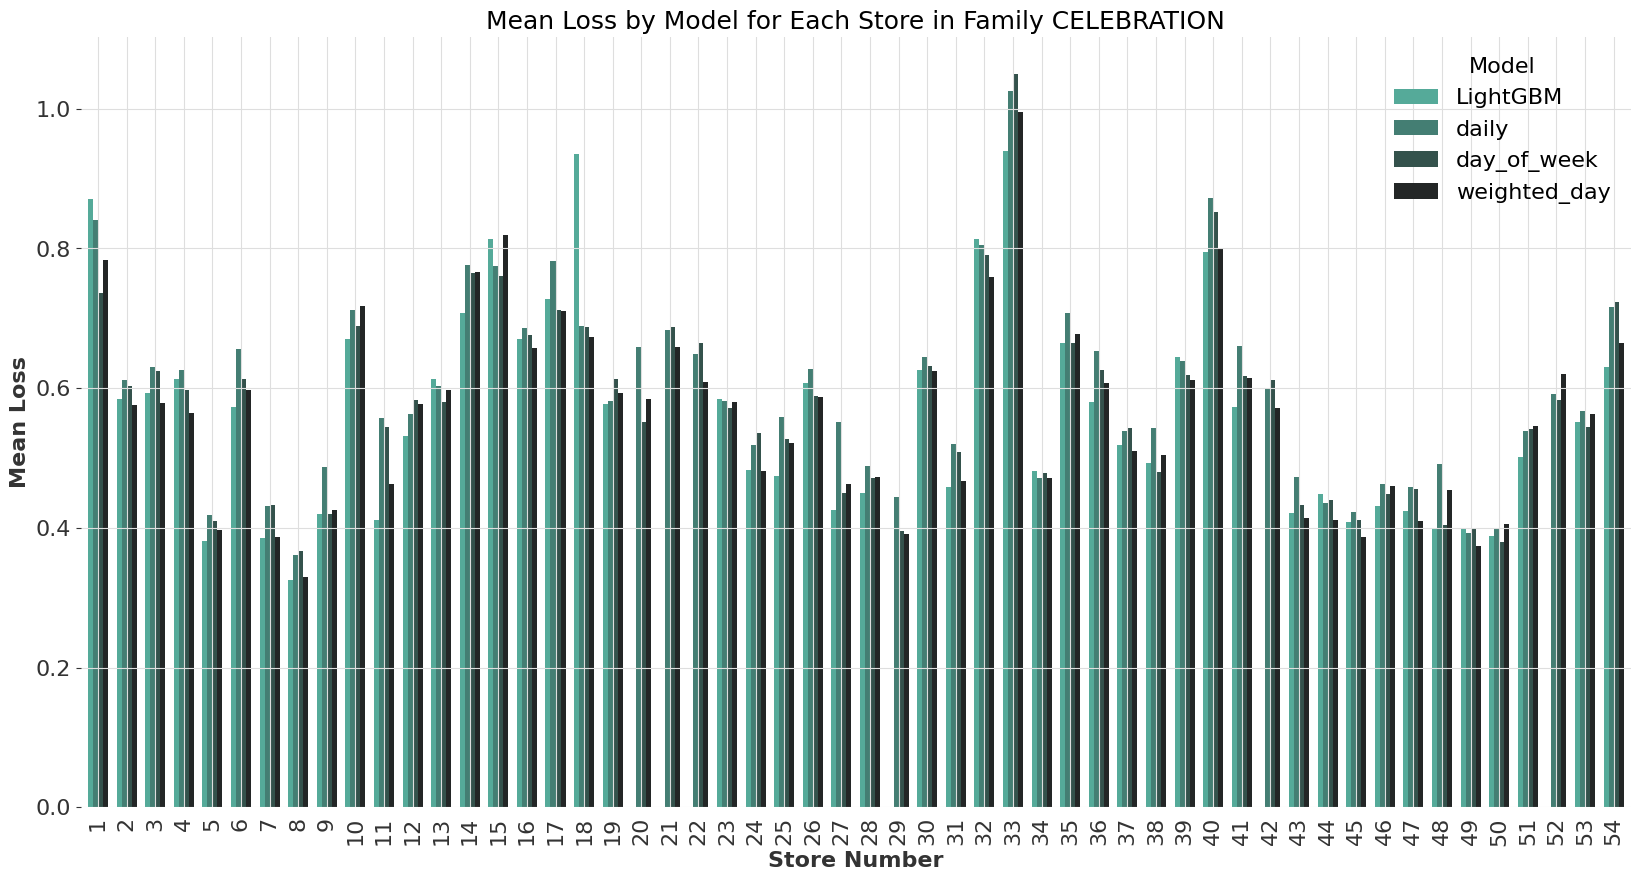

<Figure size 640x480 with 0 Axes>

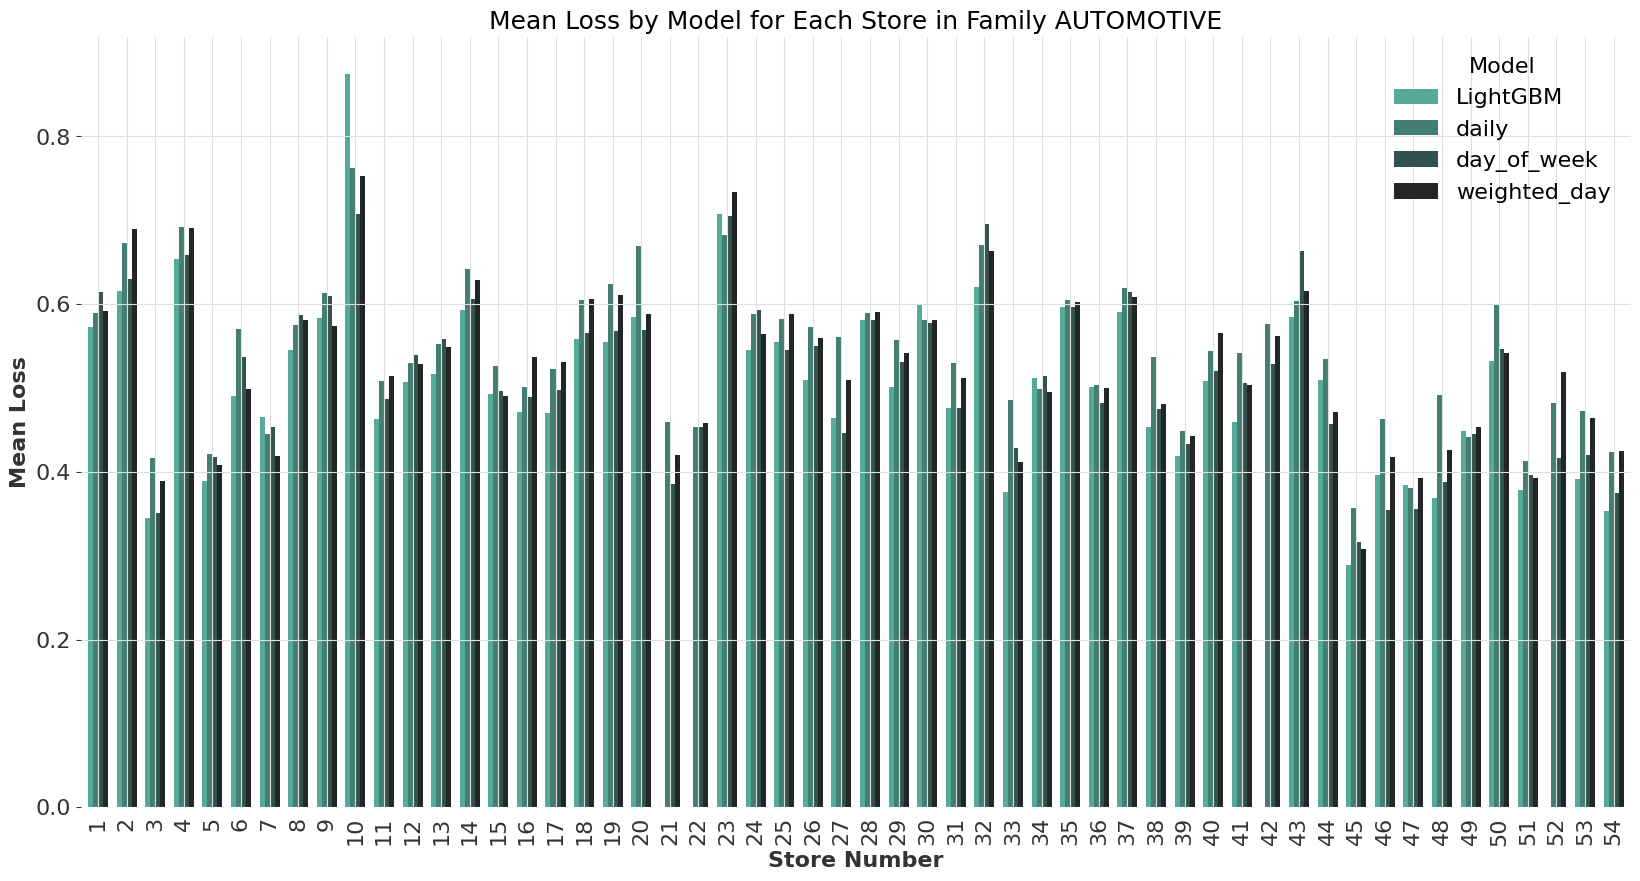

<Figure size 640x480 with 0 Axes>

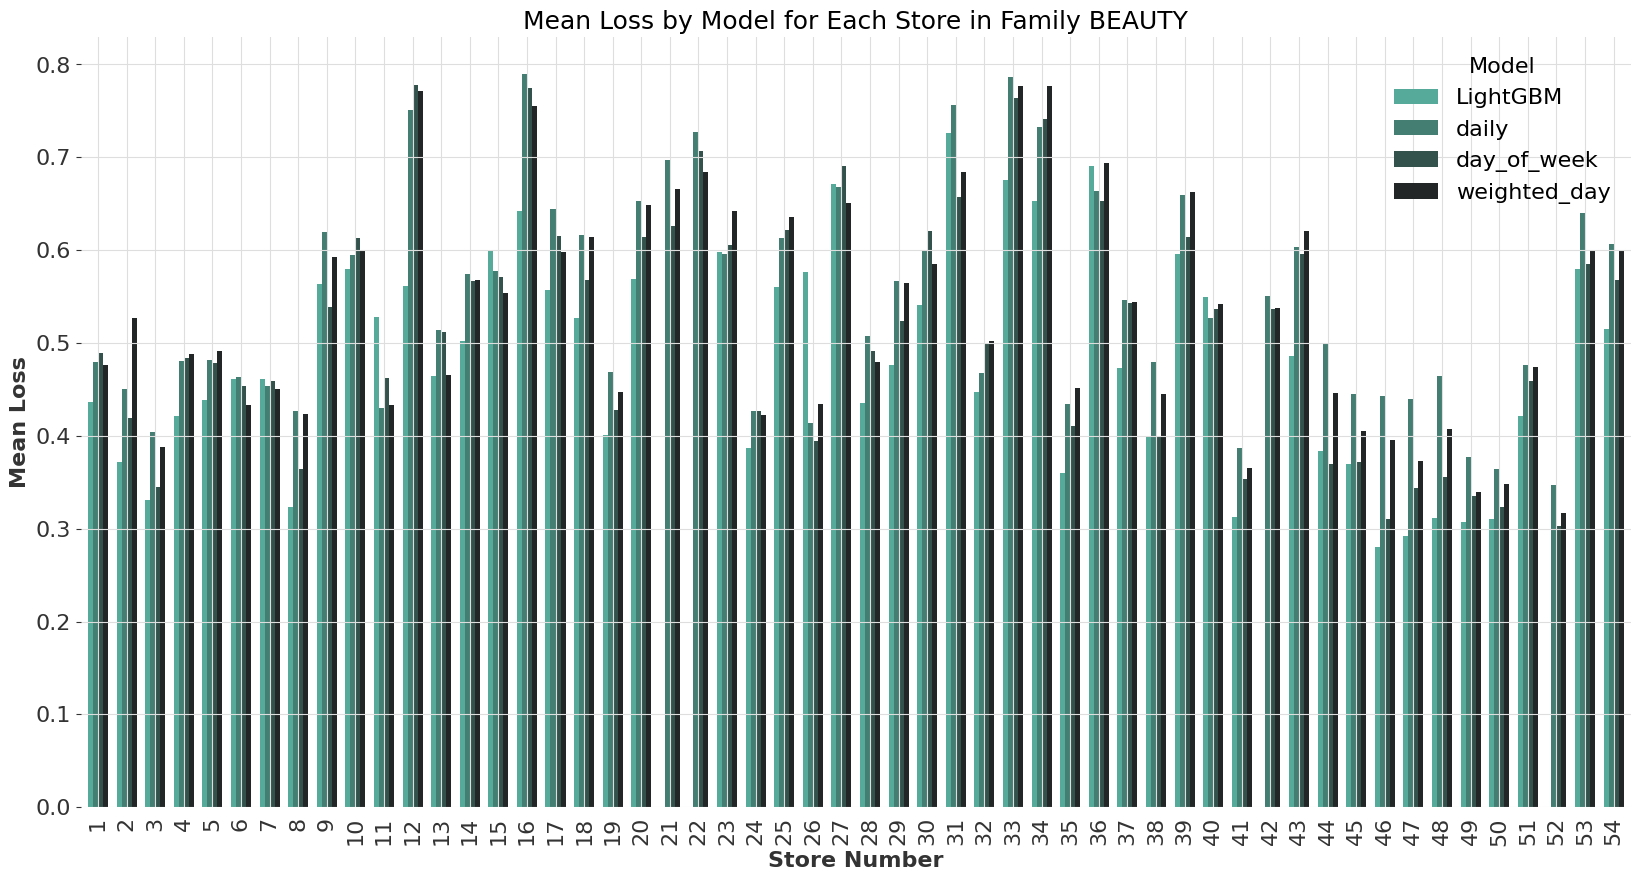

<Figure size 640x480 with 0 Axes>

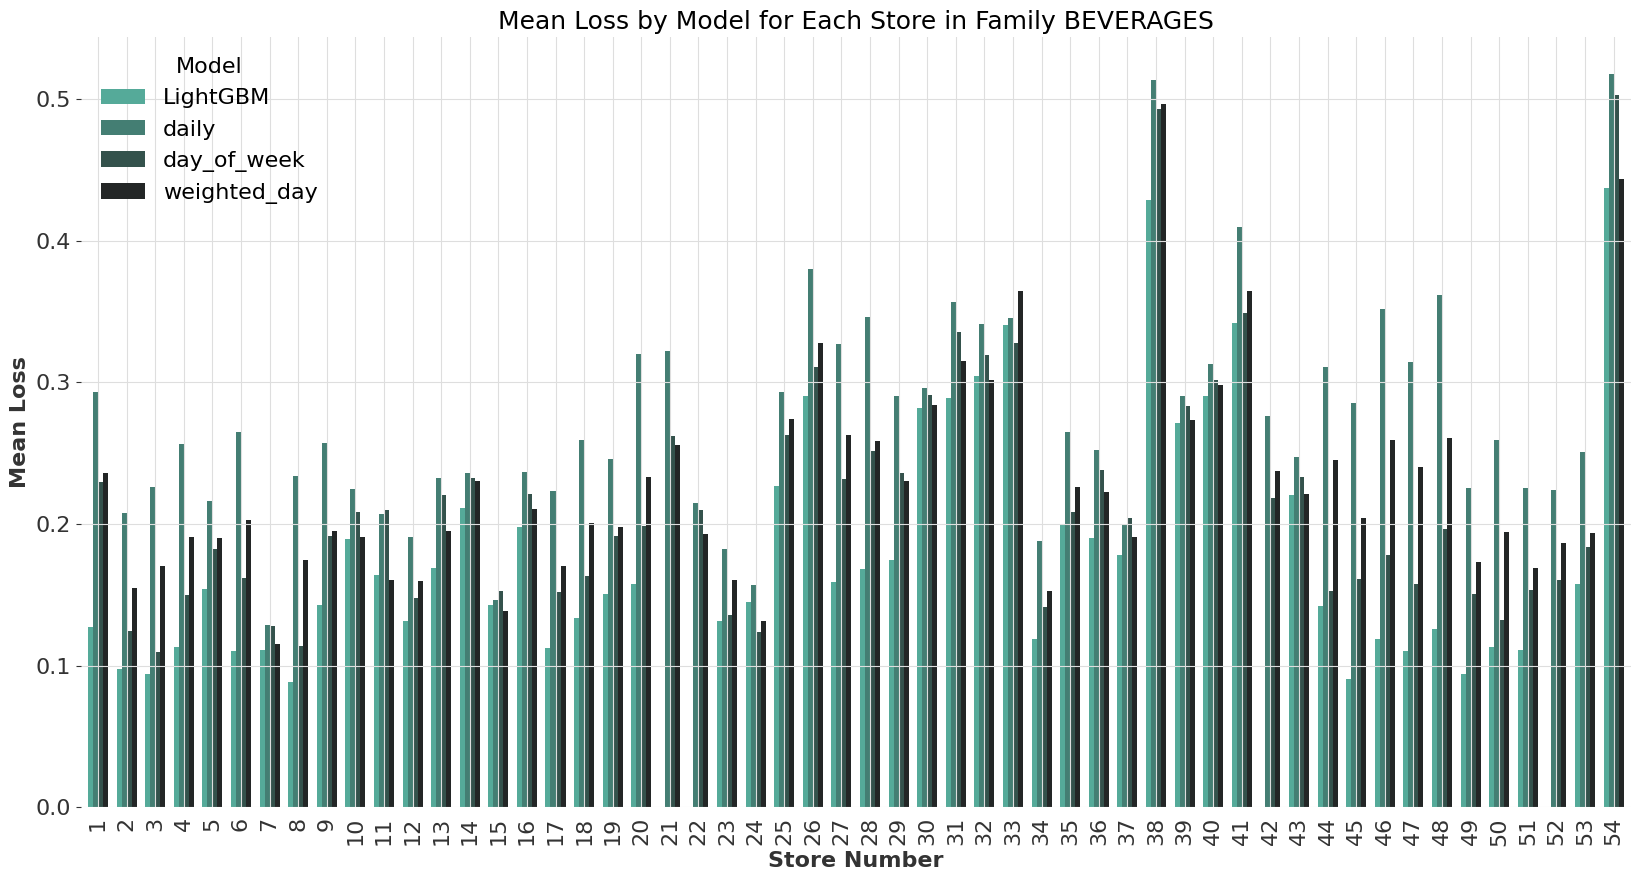

<Figure size 640x480 with 0 Axes>

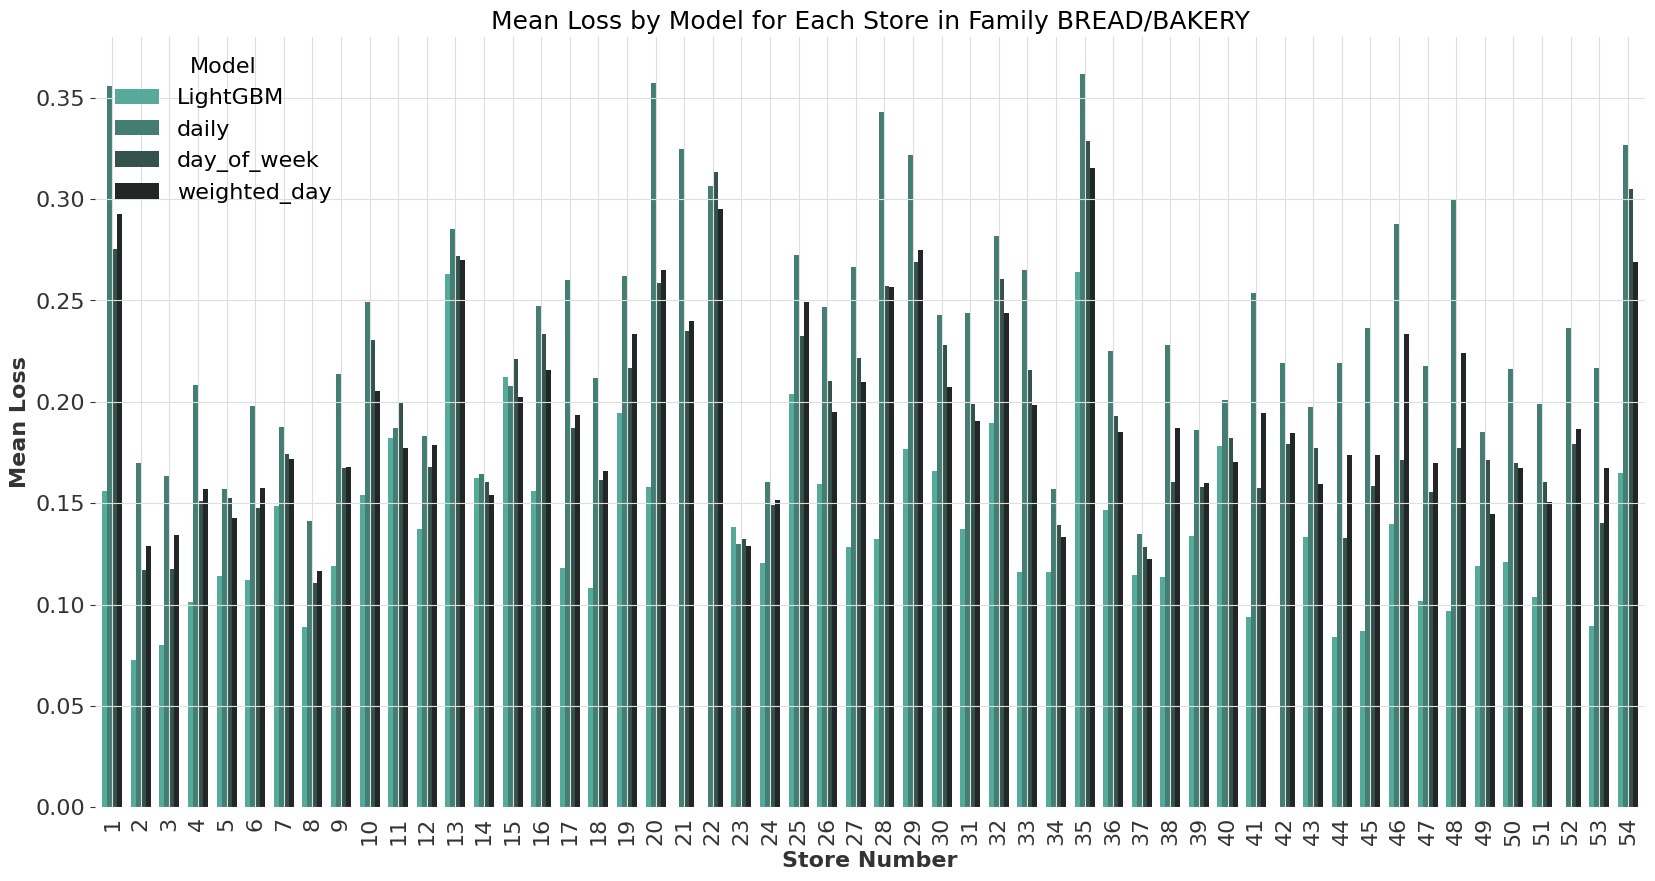

<Figure size 640x480 with 0 Axes>

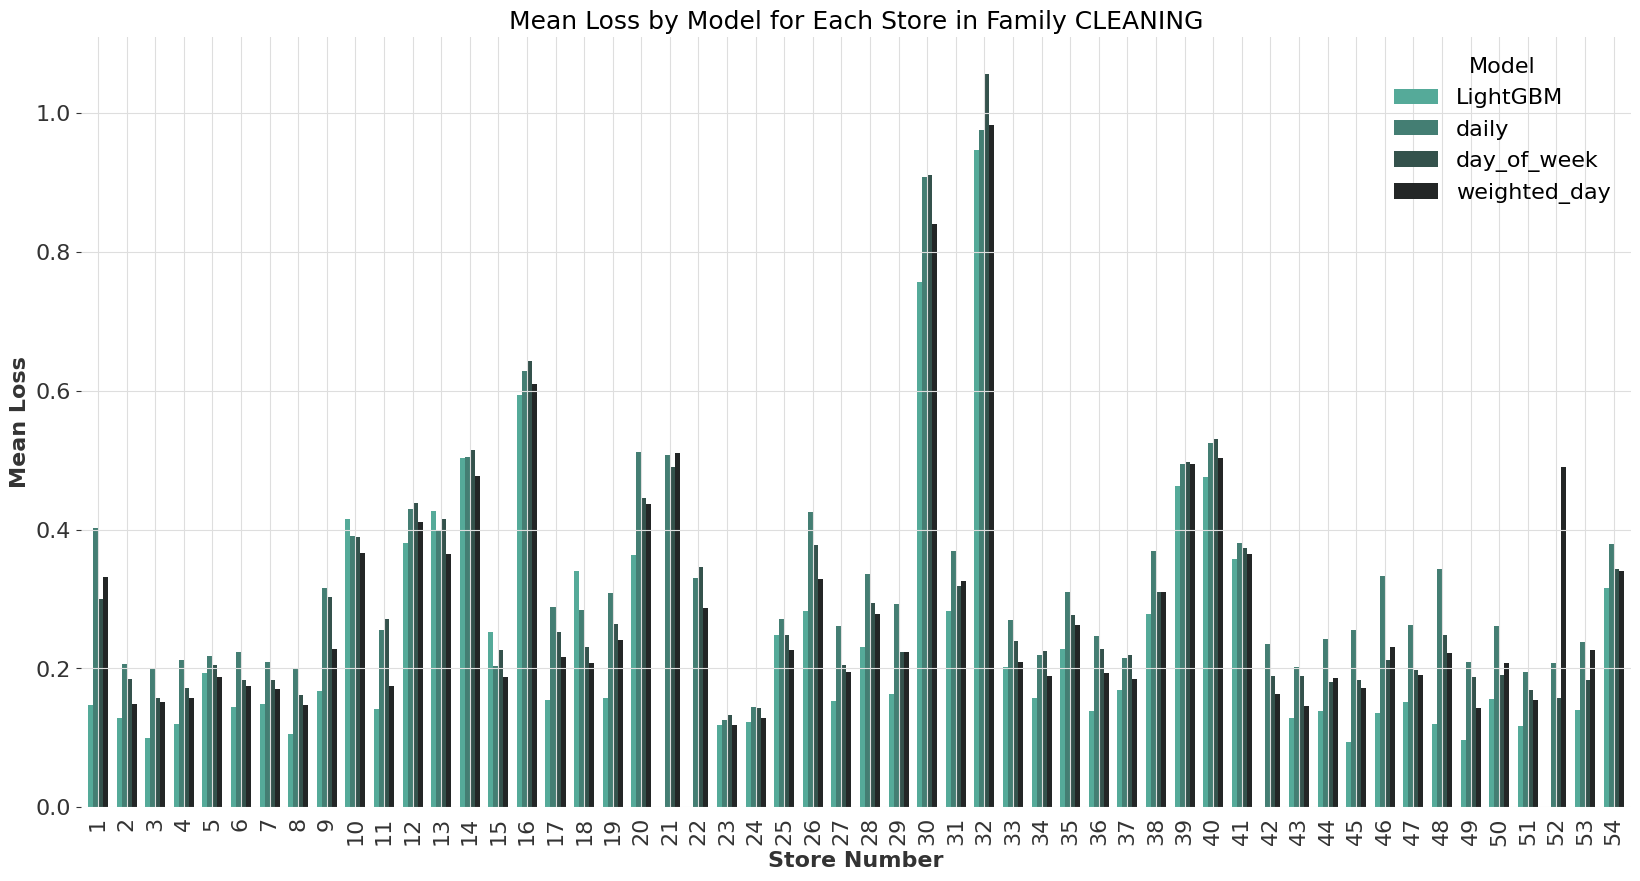

<Figure size 640x480 with 0 Axes>

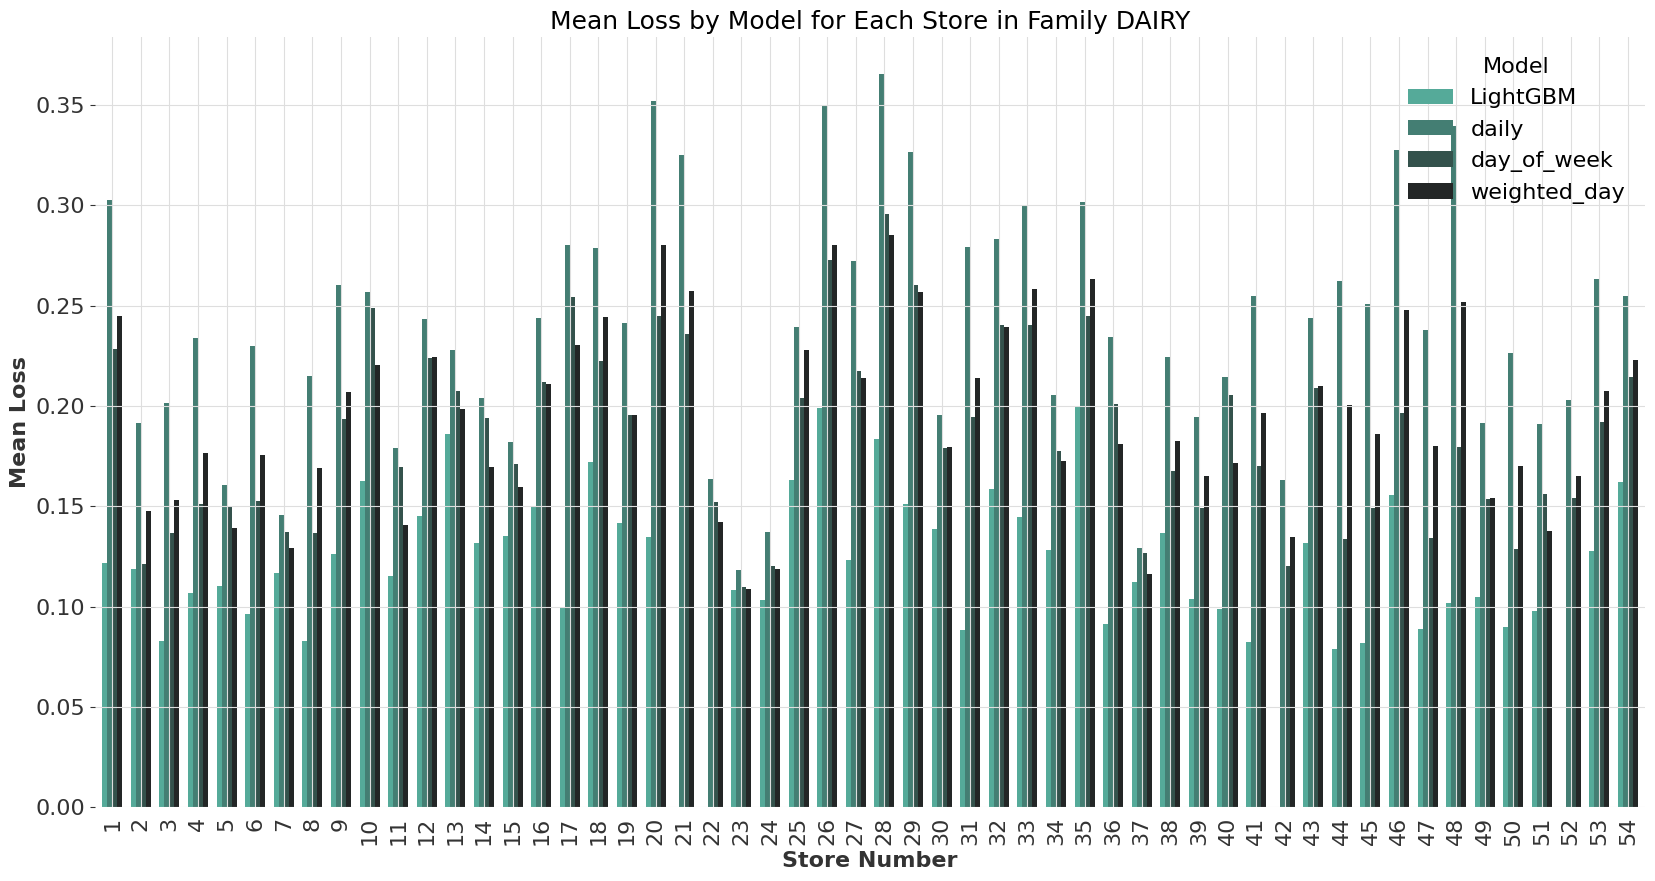

<Figure size 640x480 with 0 Axes>

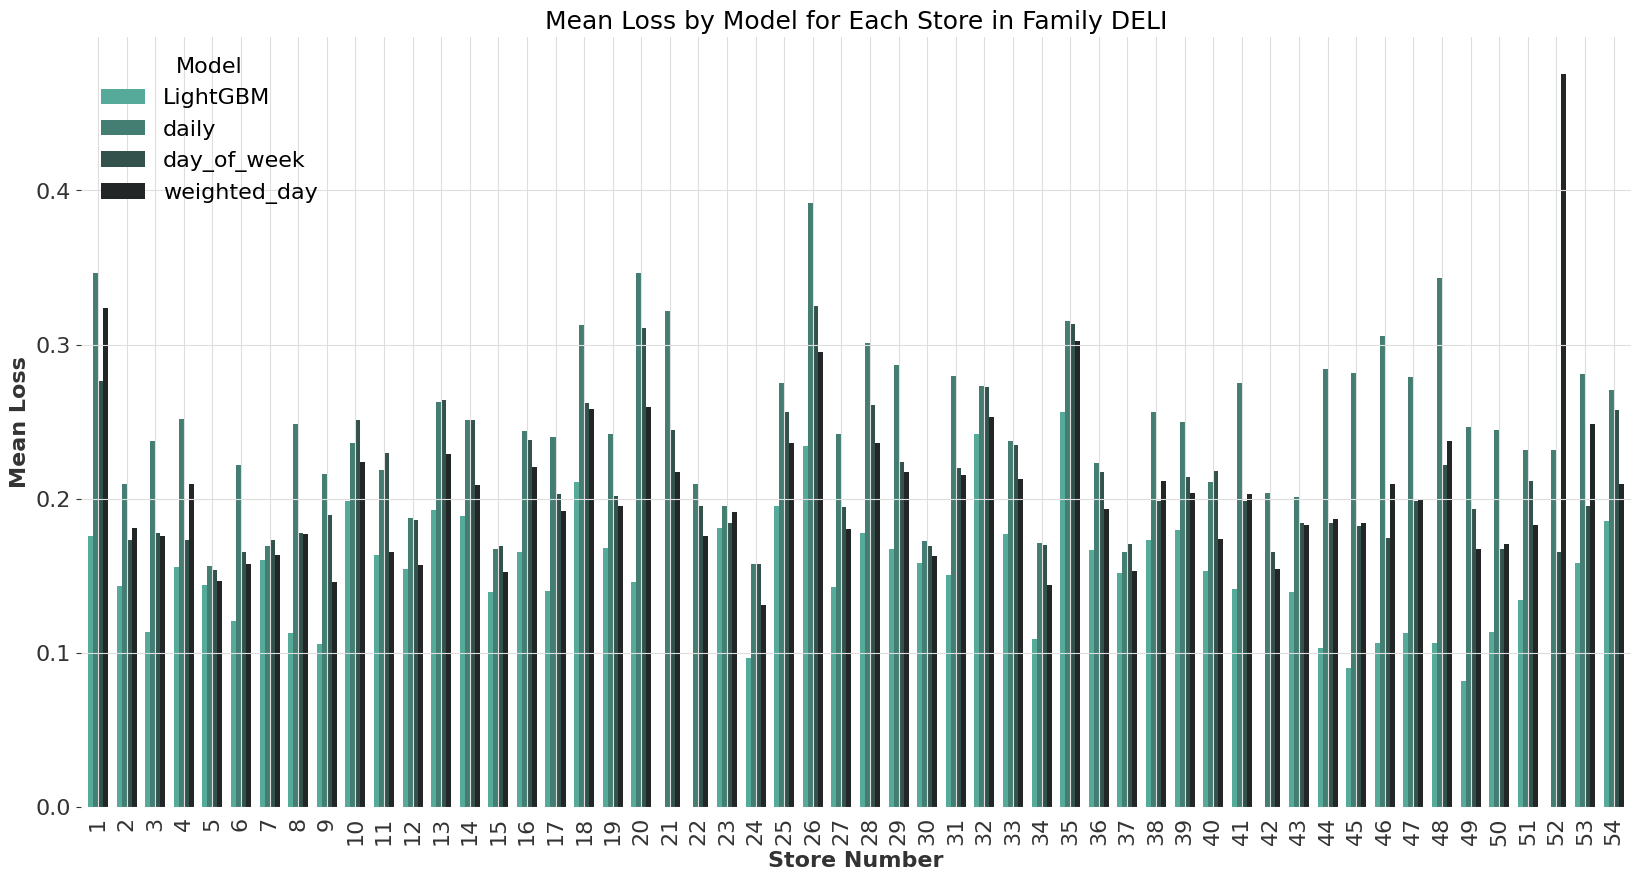

<Figure size 640x480 with 0 Axes>

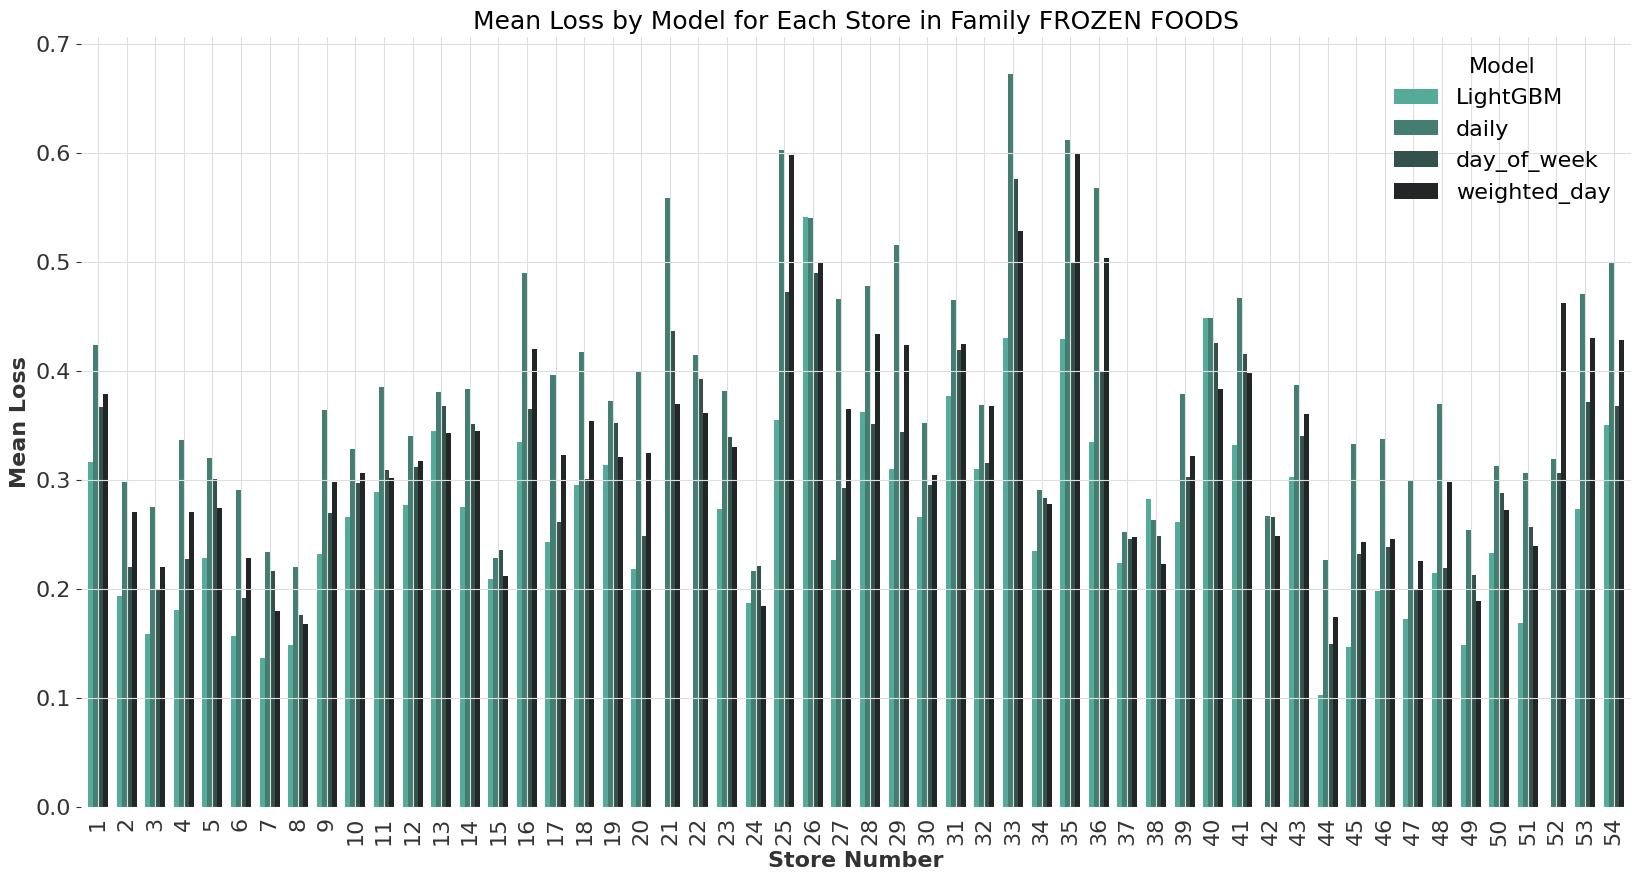

<Figure size 640x480 with 0 Axes>

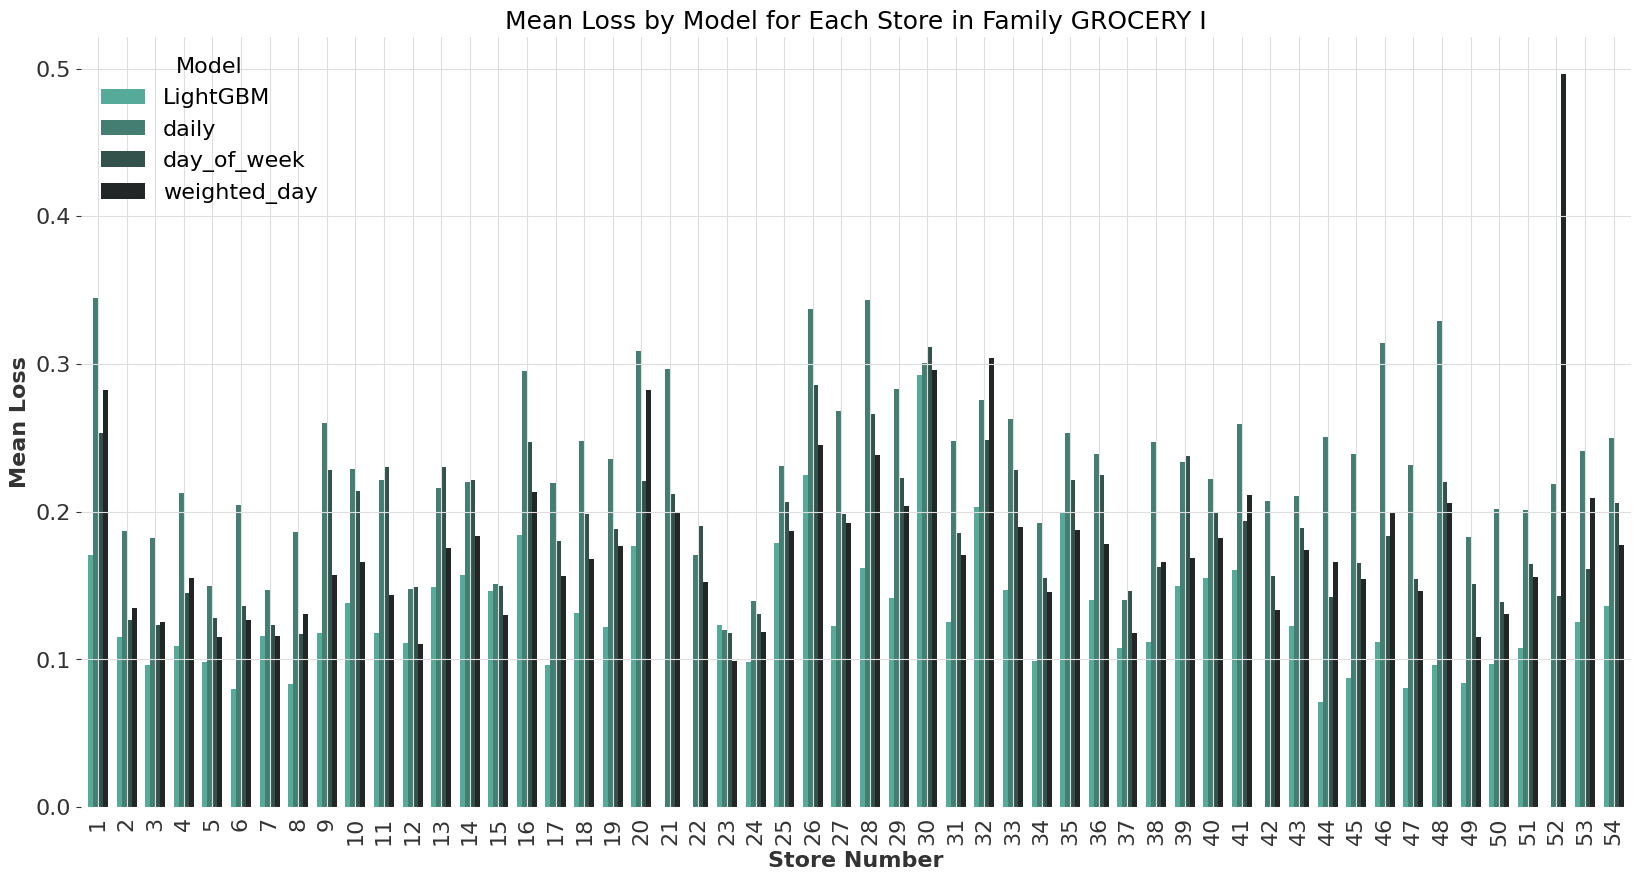

<Figure size 640x480 with 0 Axes>

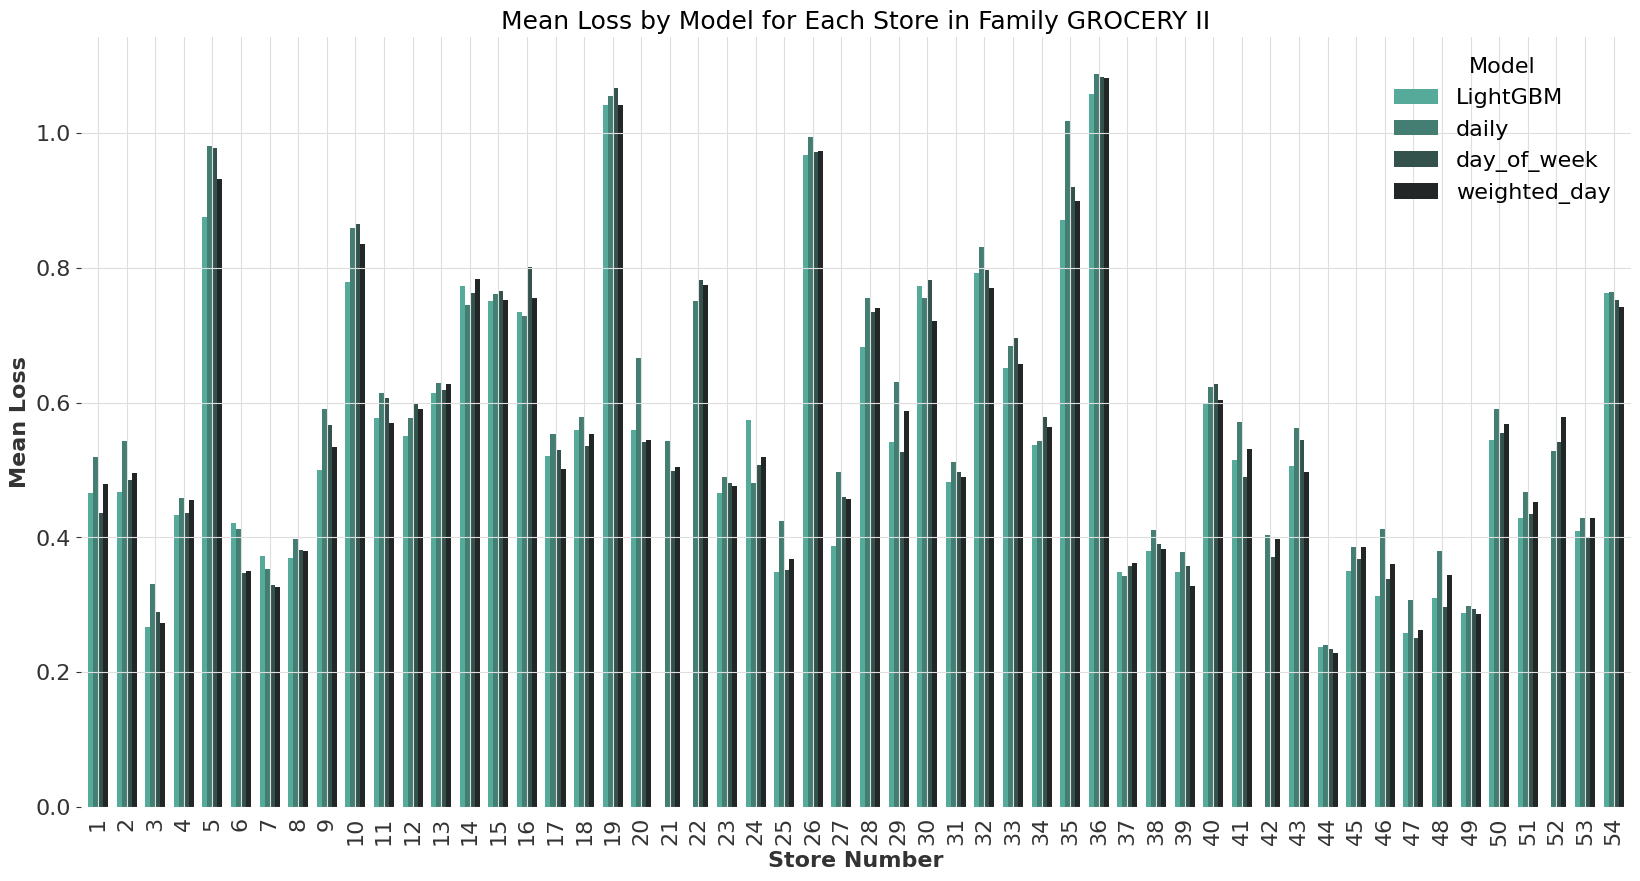

<Figure size 640x480 with 0 Axes>

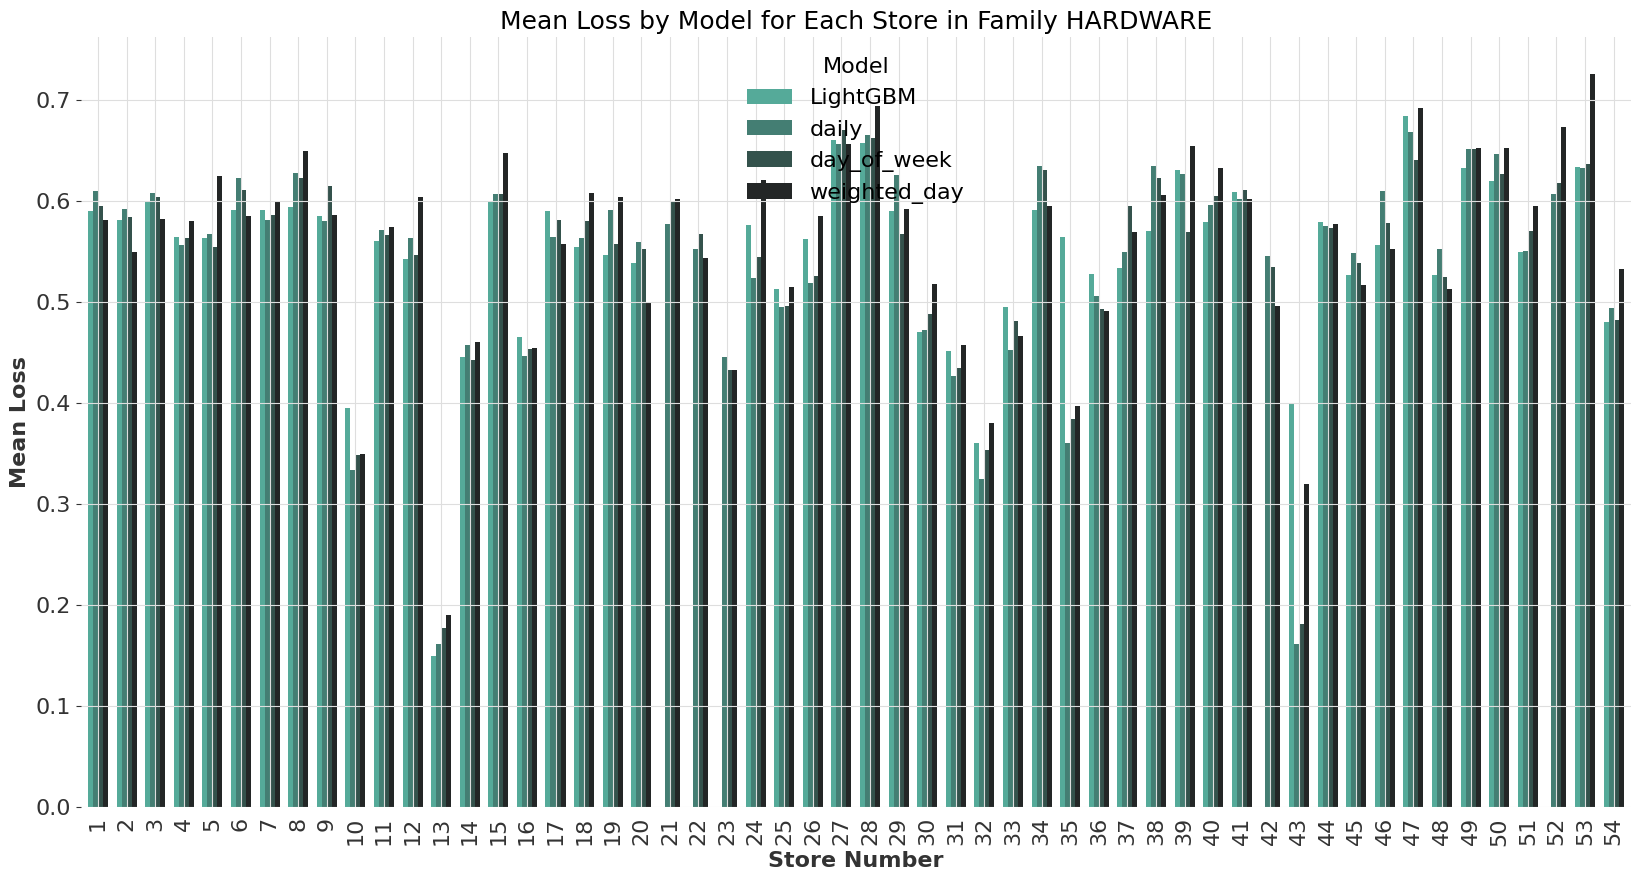

<Figure size 640x480 with 0 Axes>

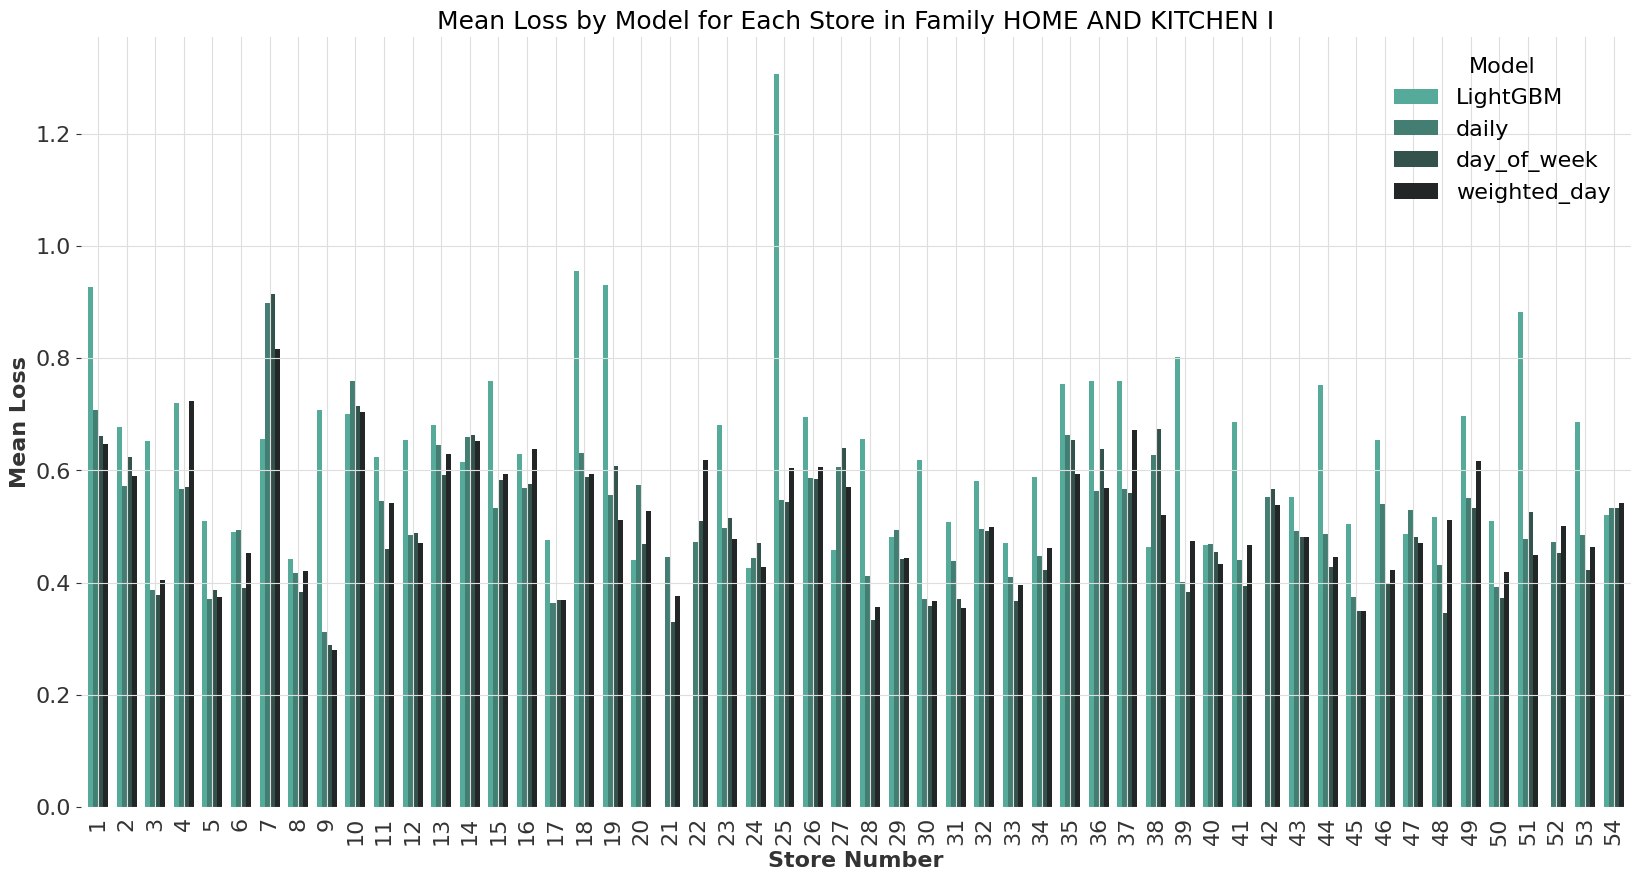

<Figure size 640x480 with 0 Axes>

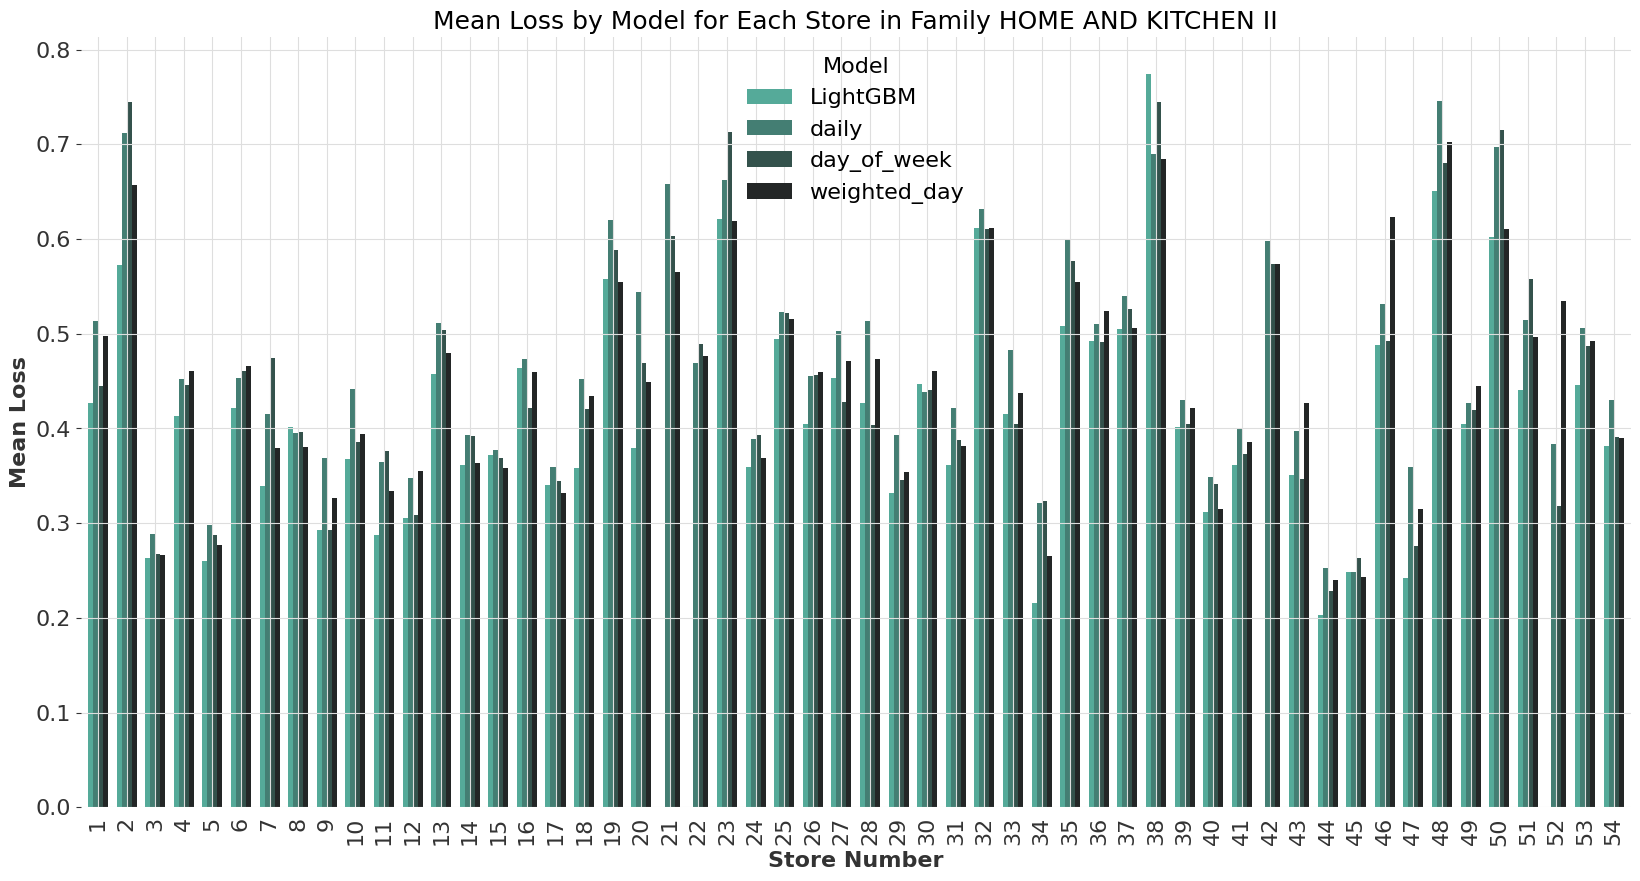

<Figure size 640x480 with 0 Axes>

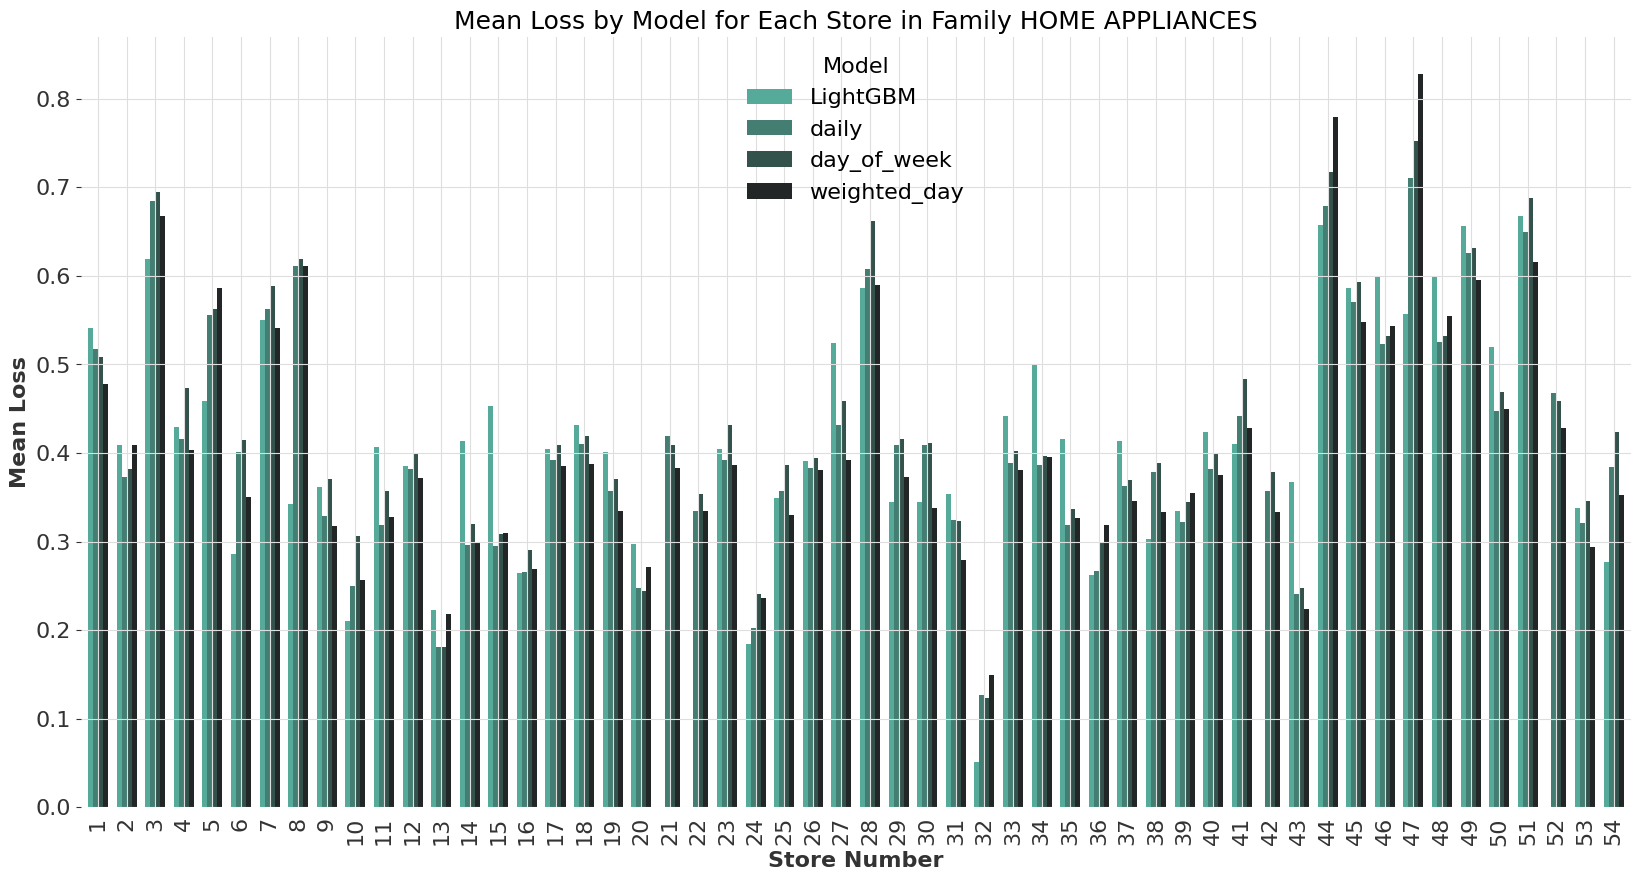

<Figure size 640x480 with 0 Axes>

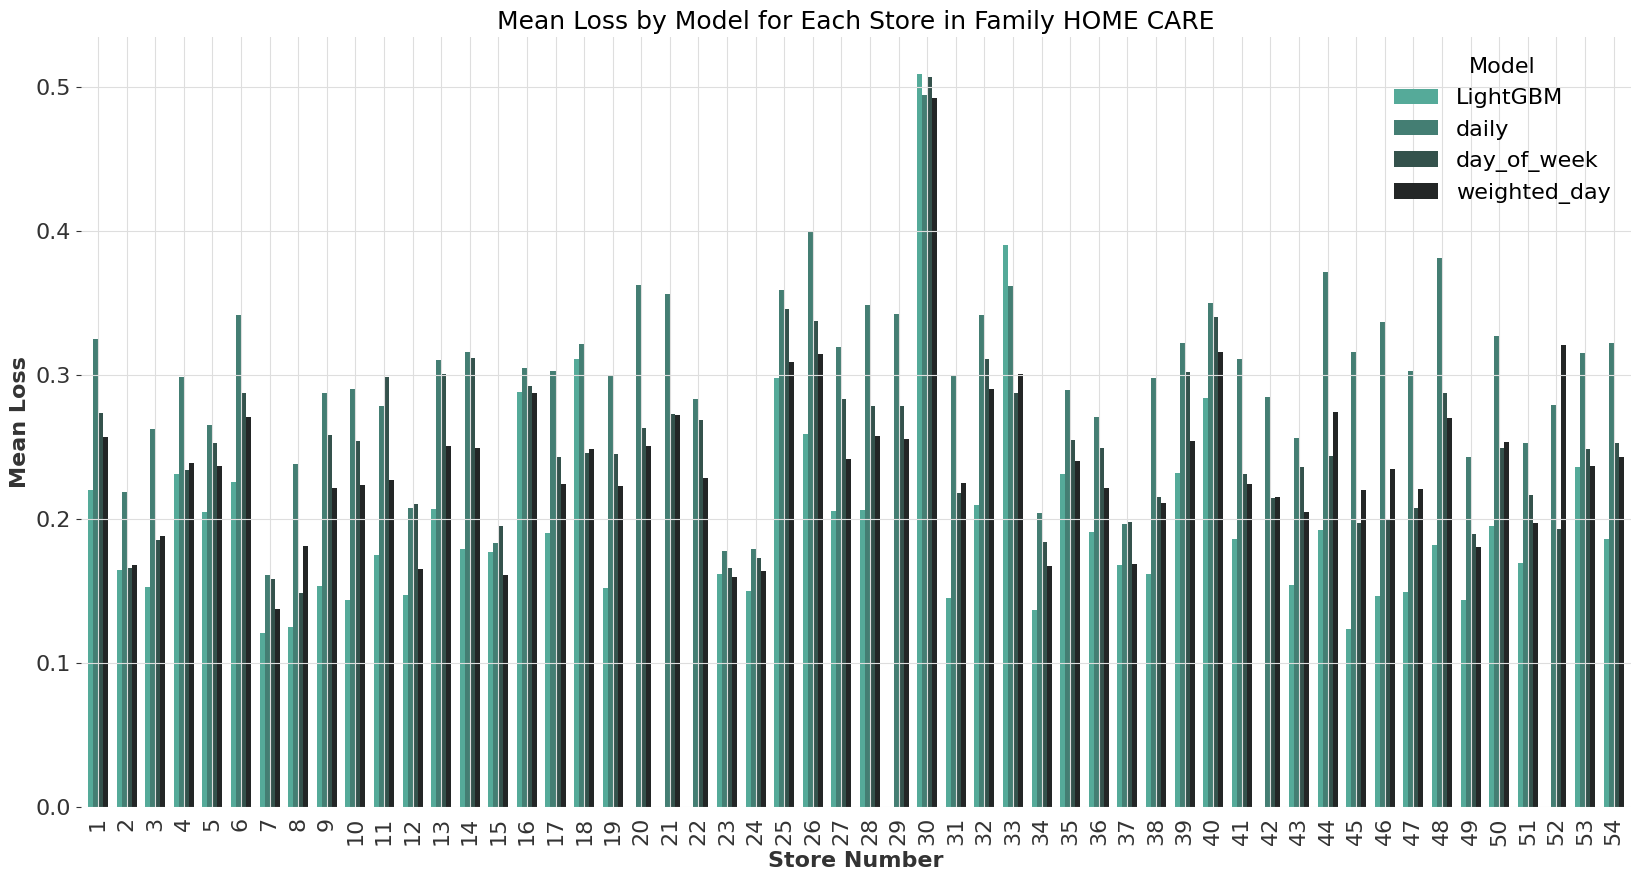

<Figure size 640x480 with 0 Axes>

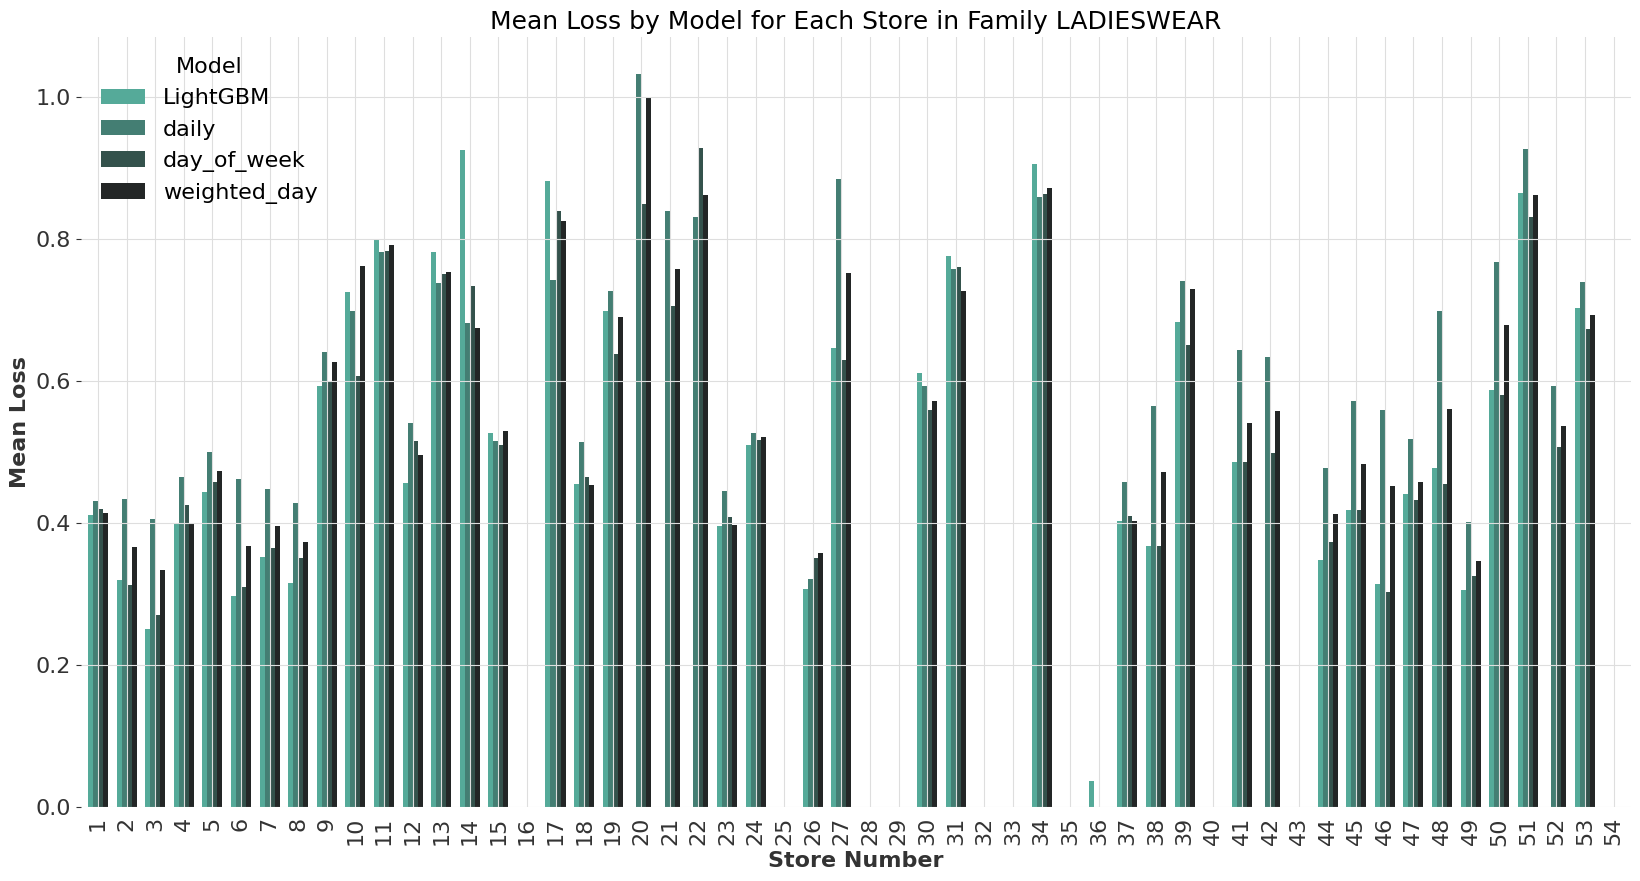

<Figure size 640x480 with 0 Axes>

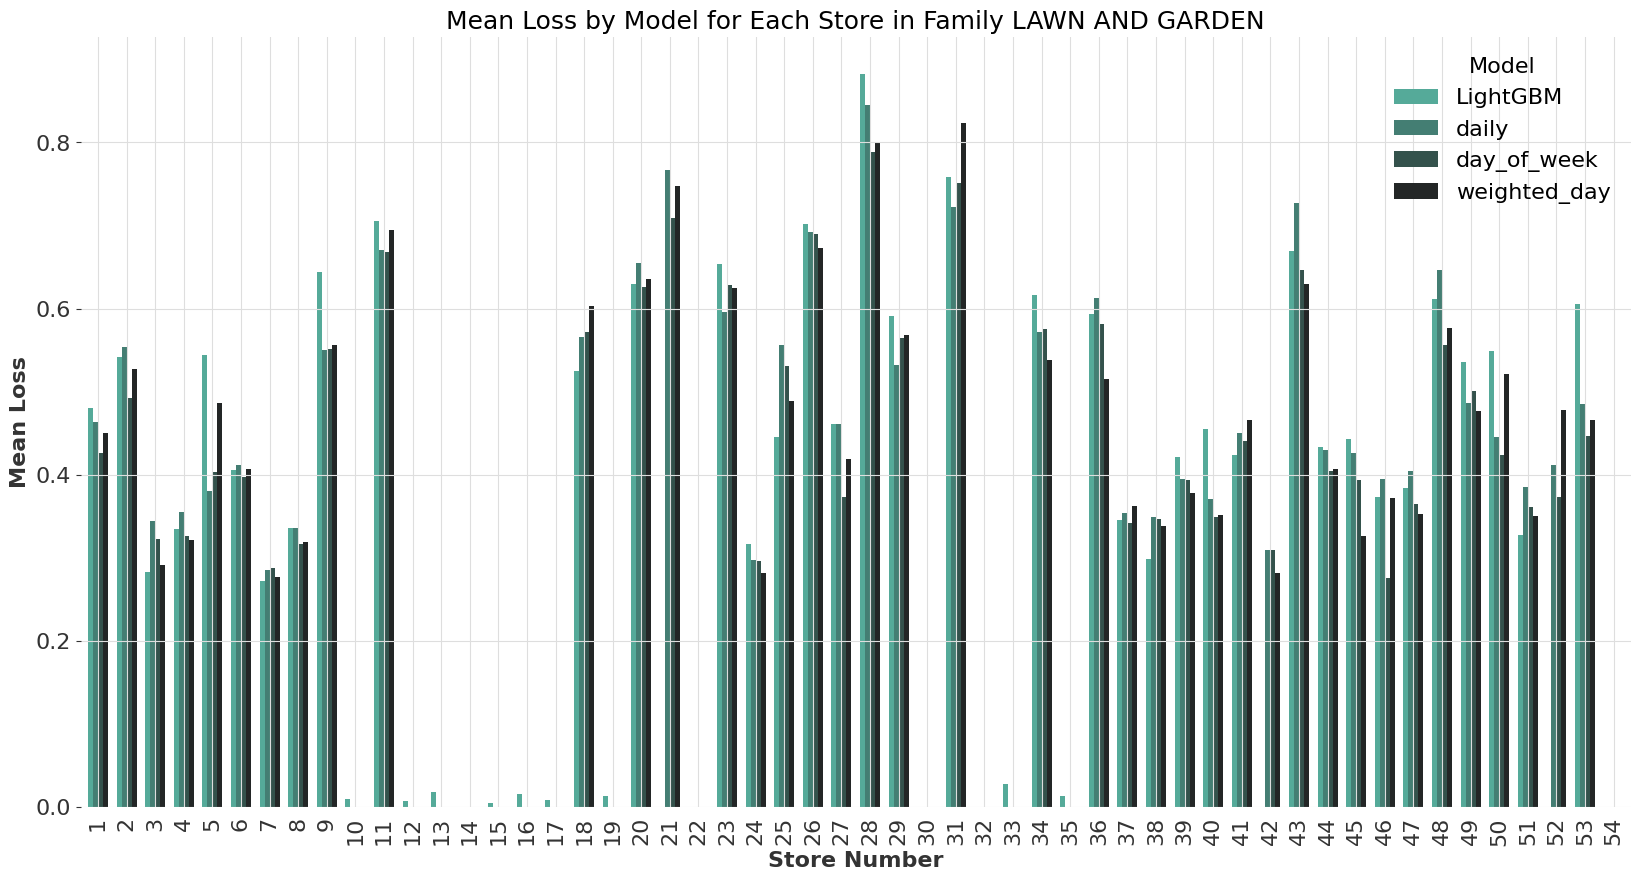

<Figure size 640x480 with 0 Axes>

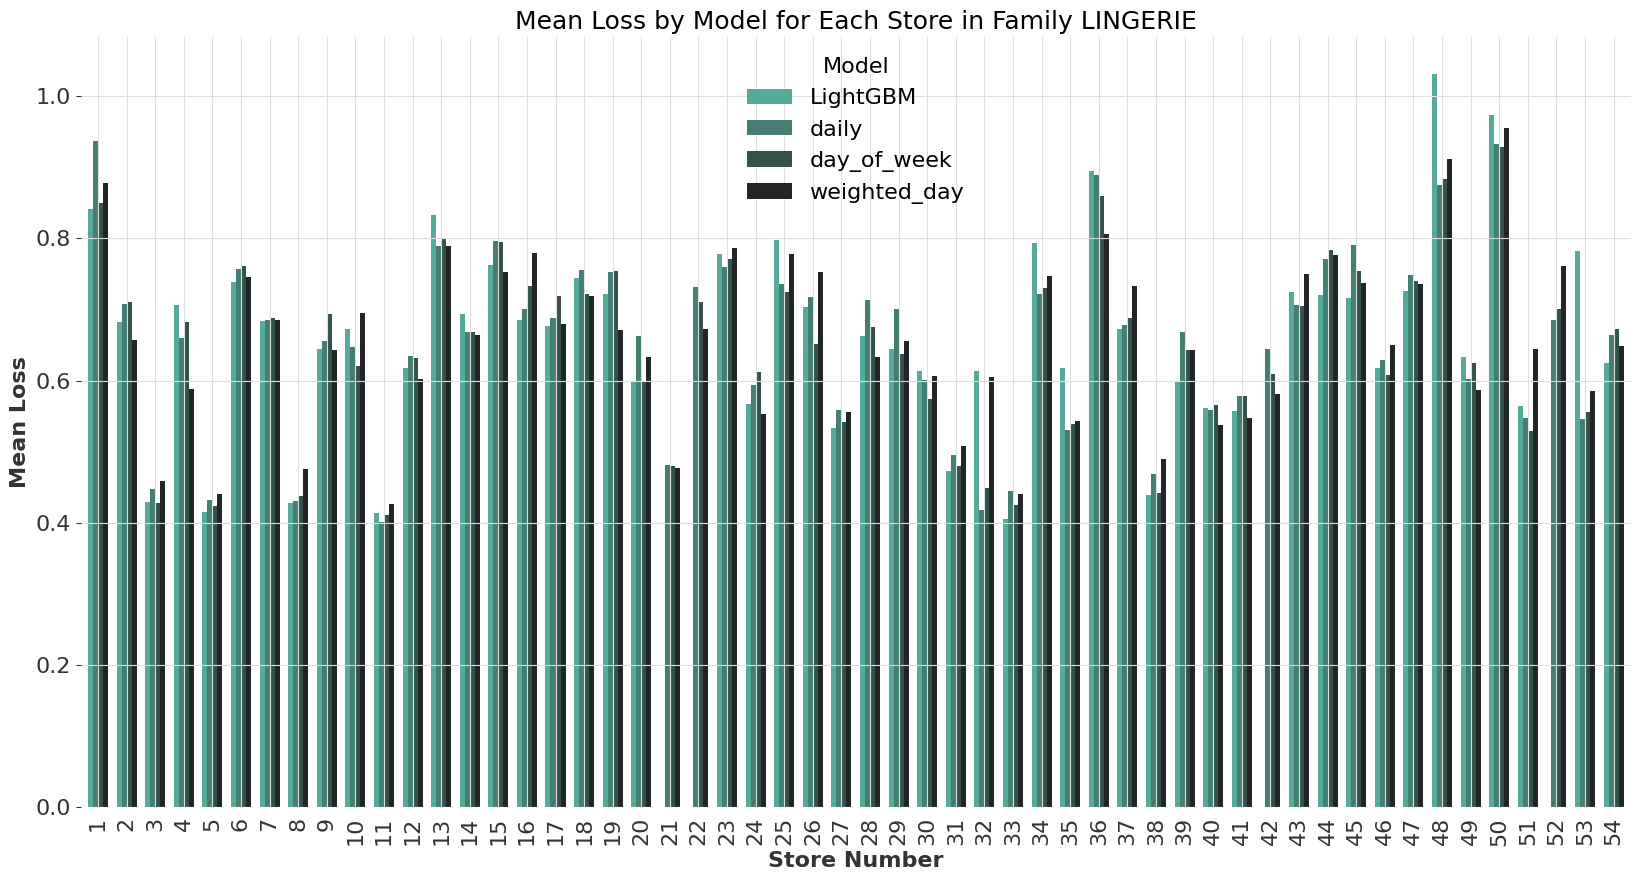

<Figure size 640x480 with 0 Axes>

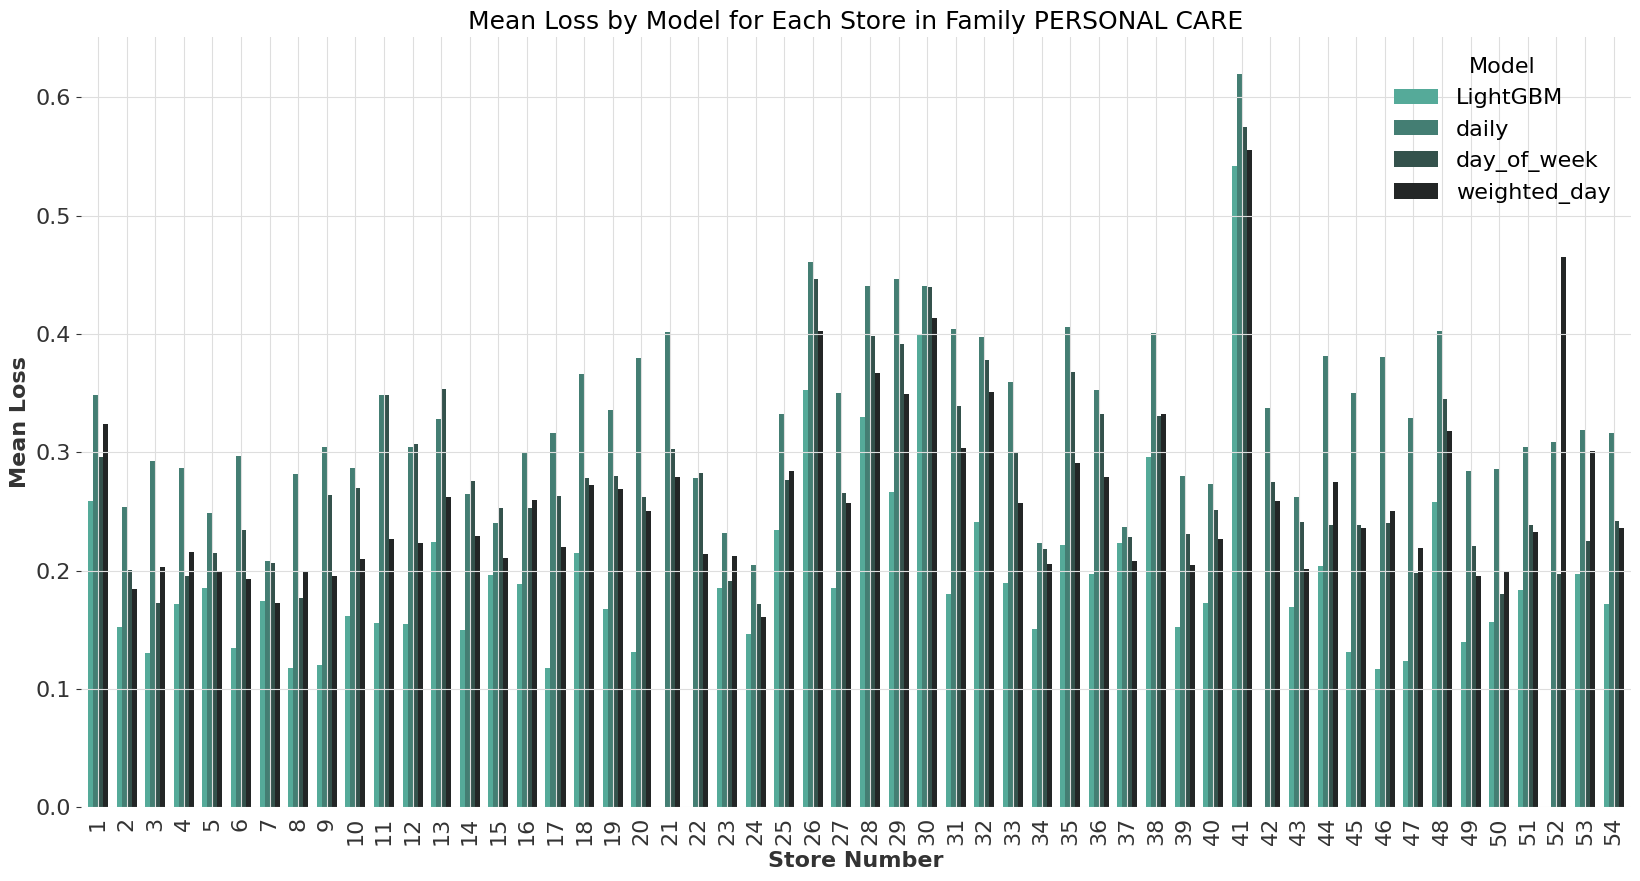

<Figure size 640x480 with 0 Axes>

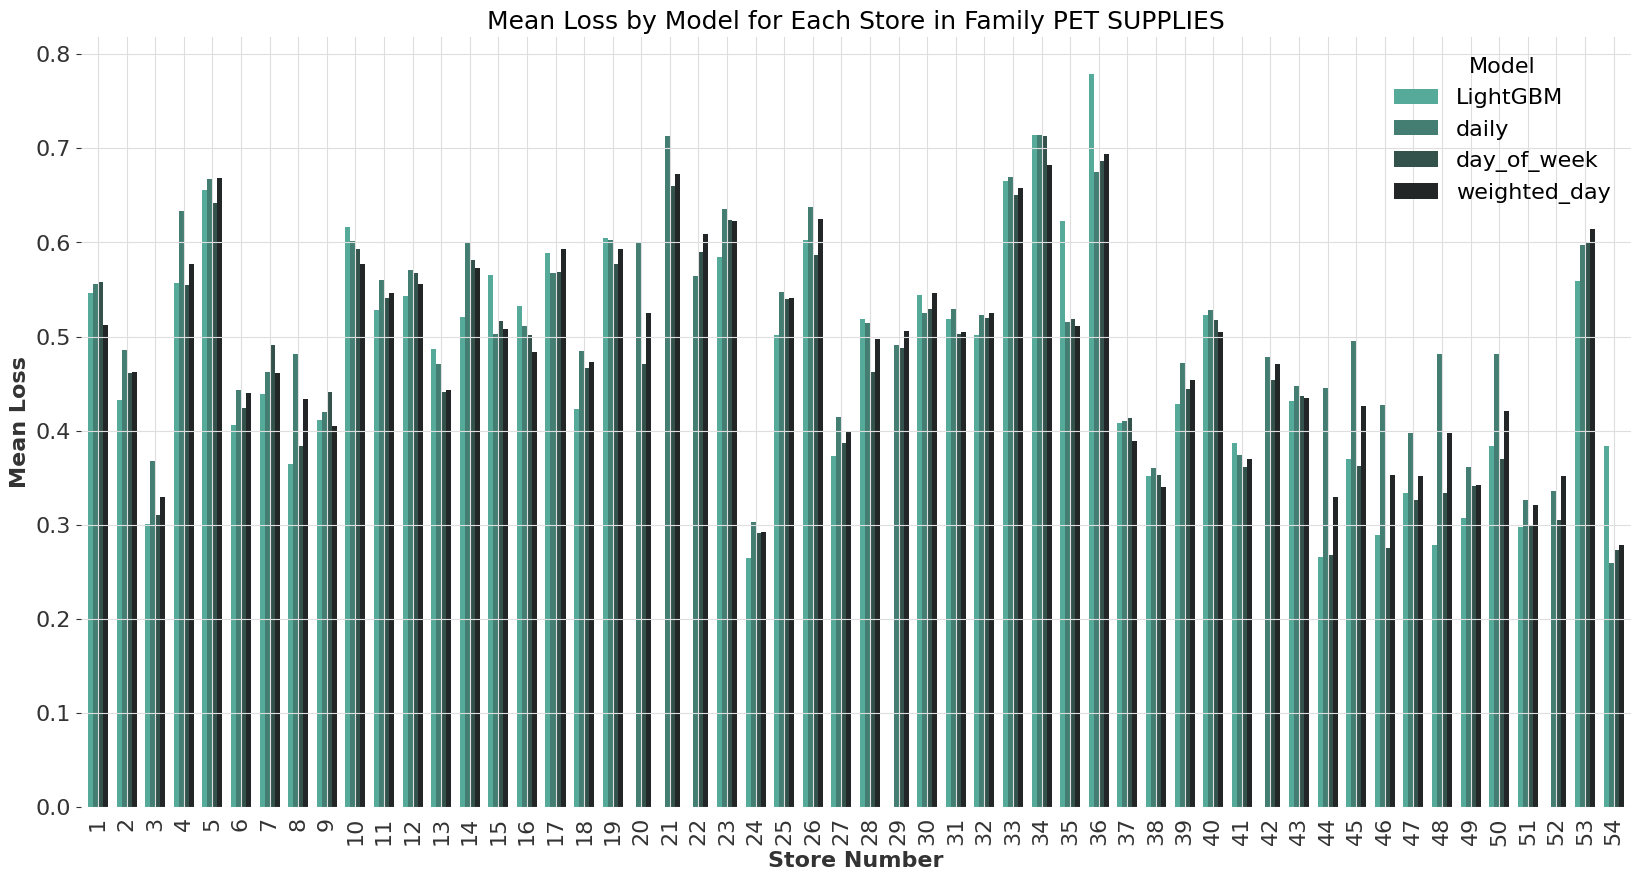

<Figure size 640x480 with 0 Axes>

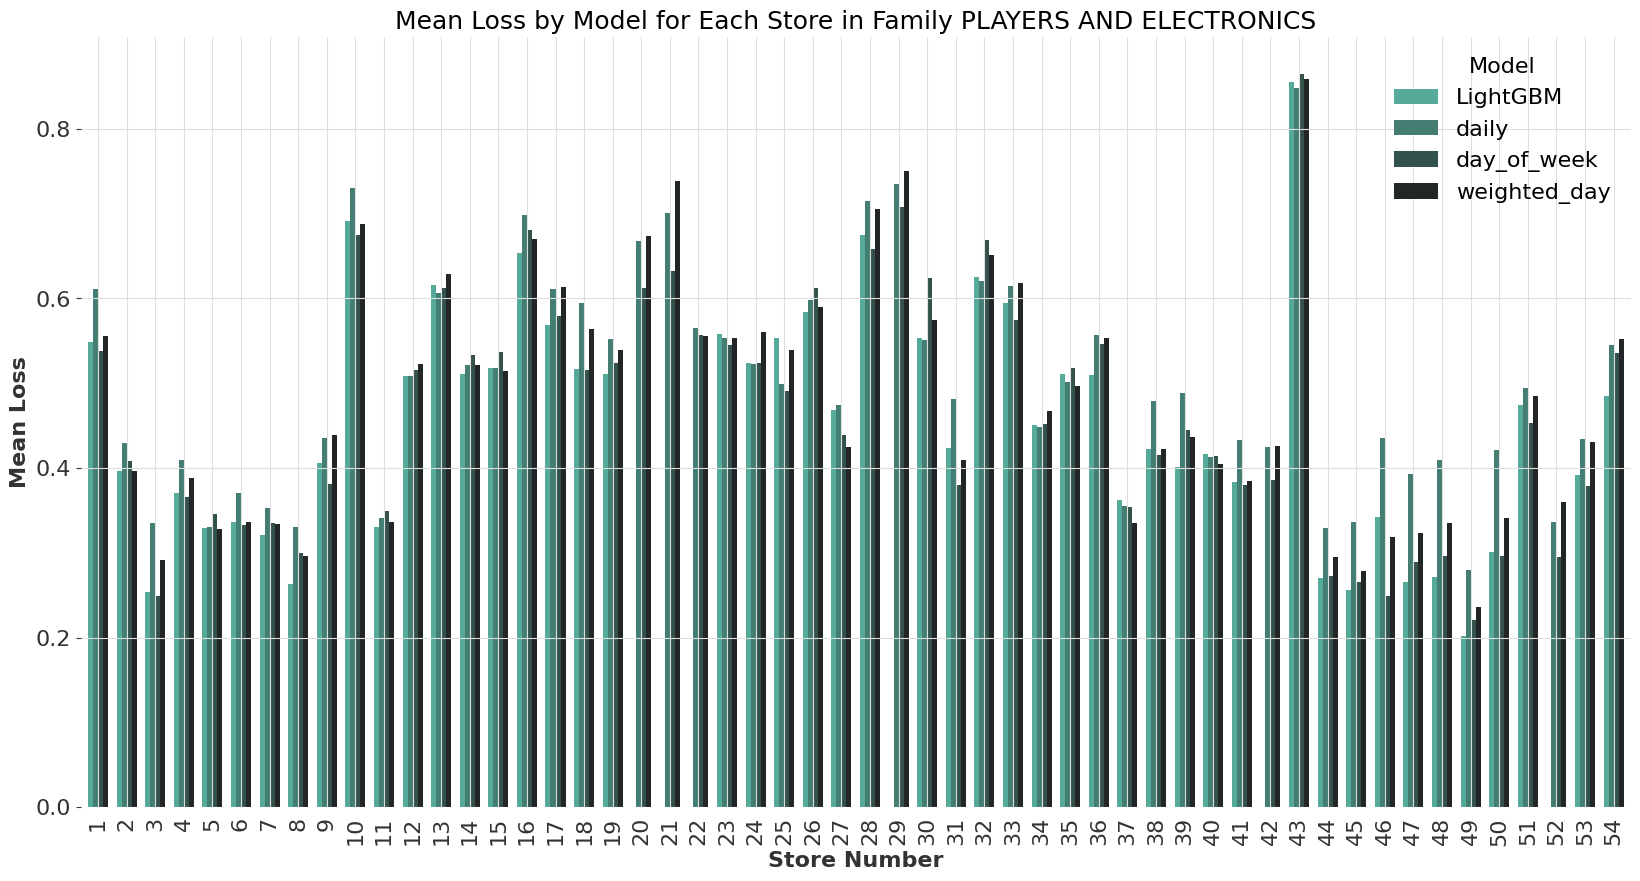

<Figure size 640x480 with 0 Axes>

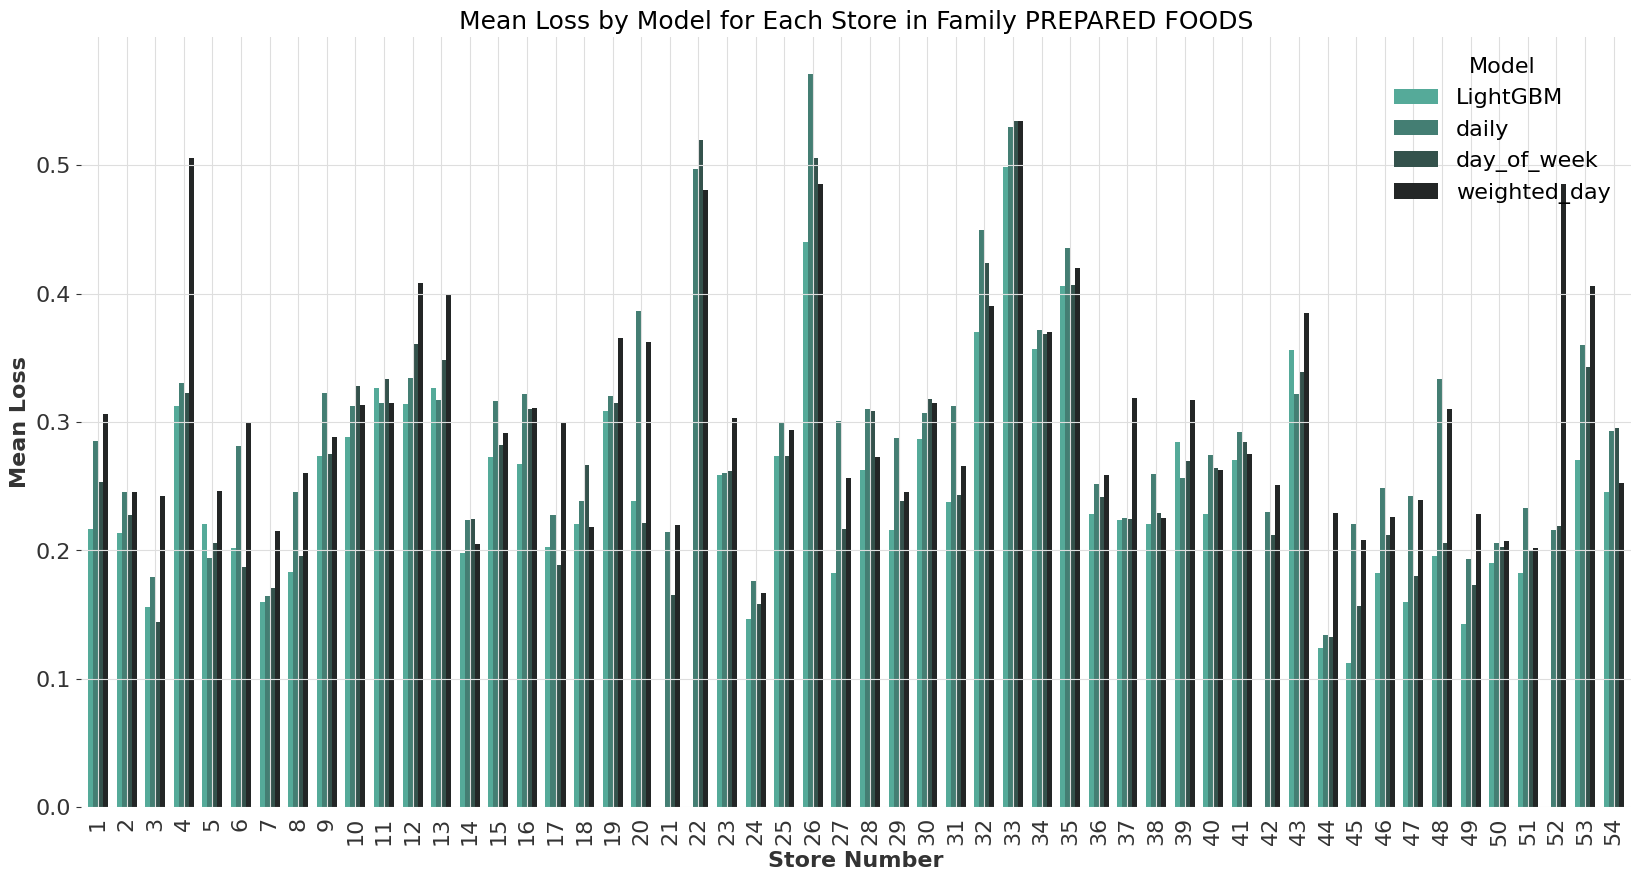

<Figure size 640x480 with 0 Axes>

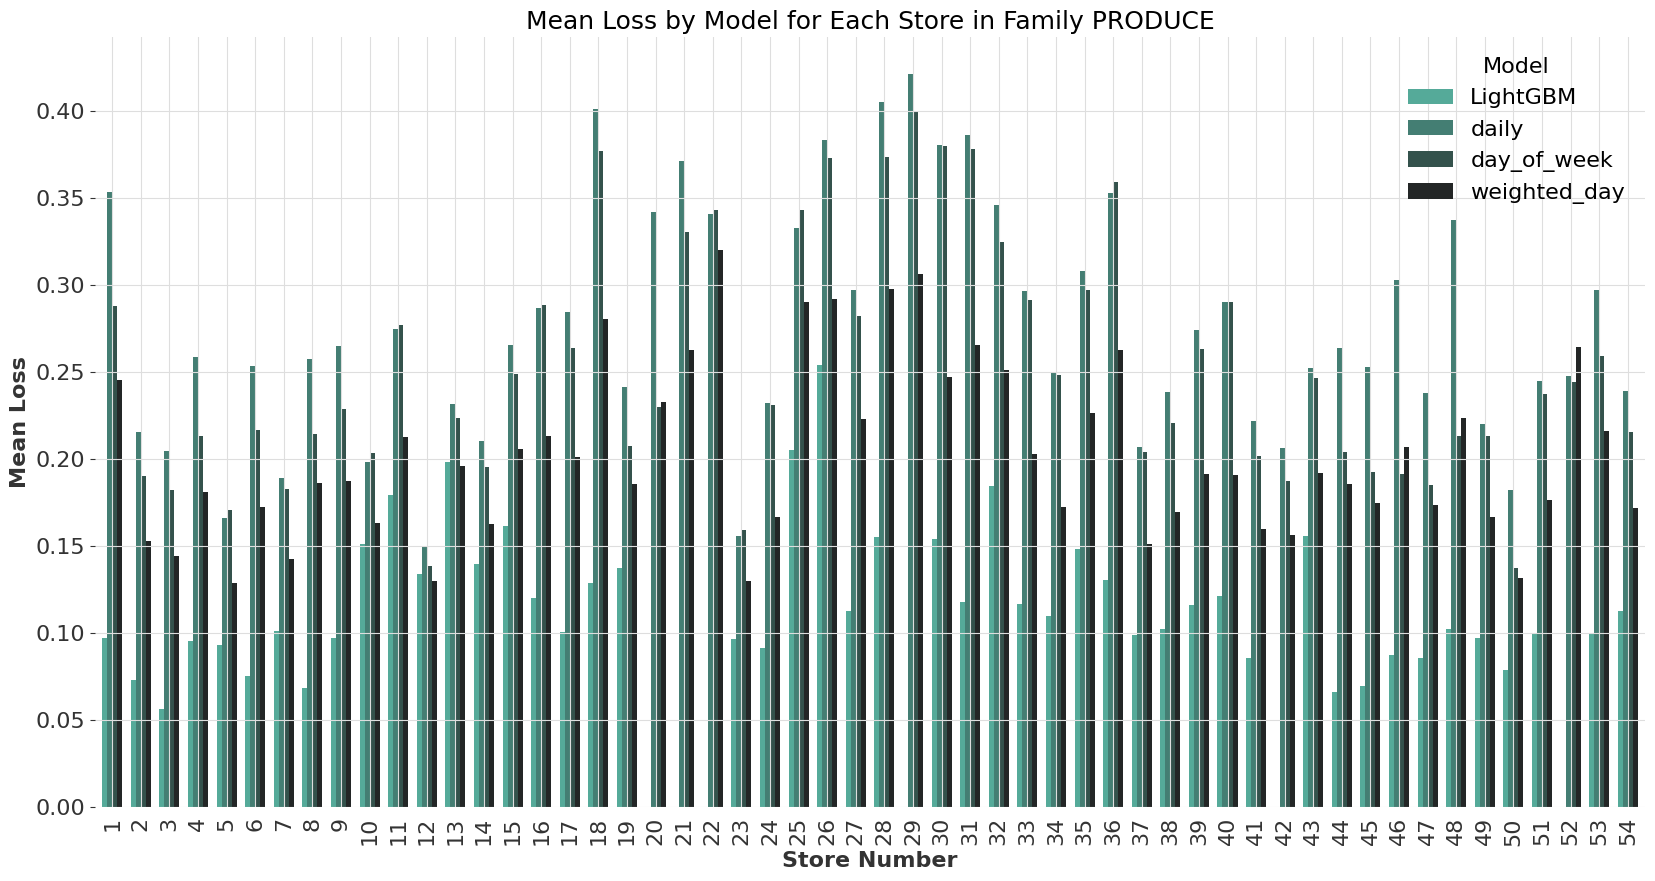

<Figure size 640x480 with 0 Axes>

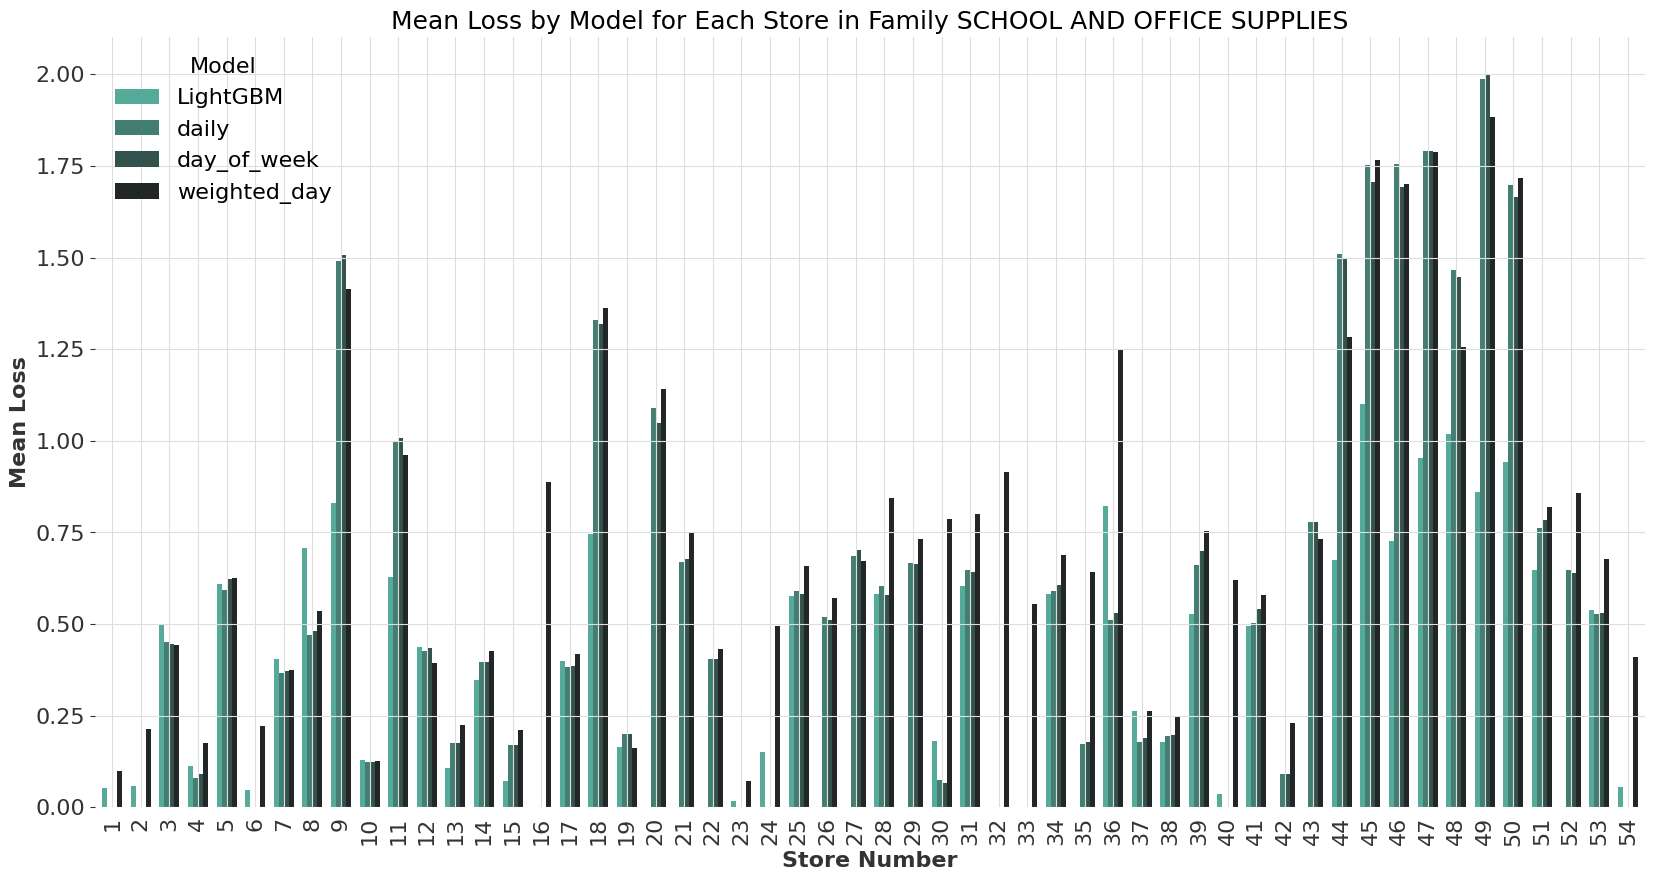

<Figure size 640x480 with 0 Axes>

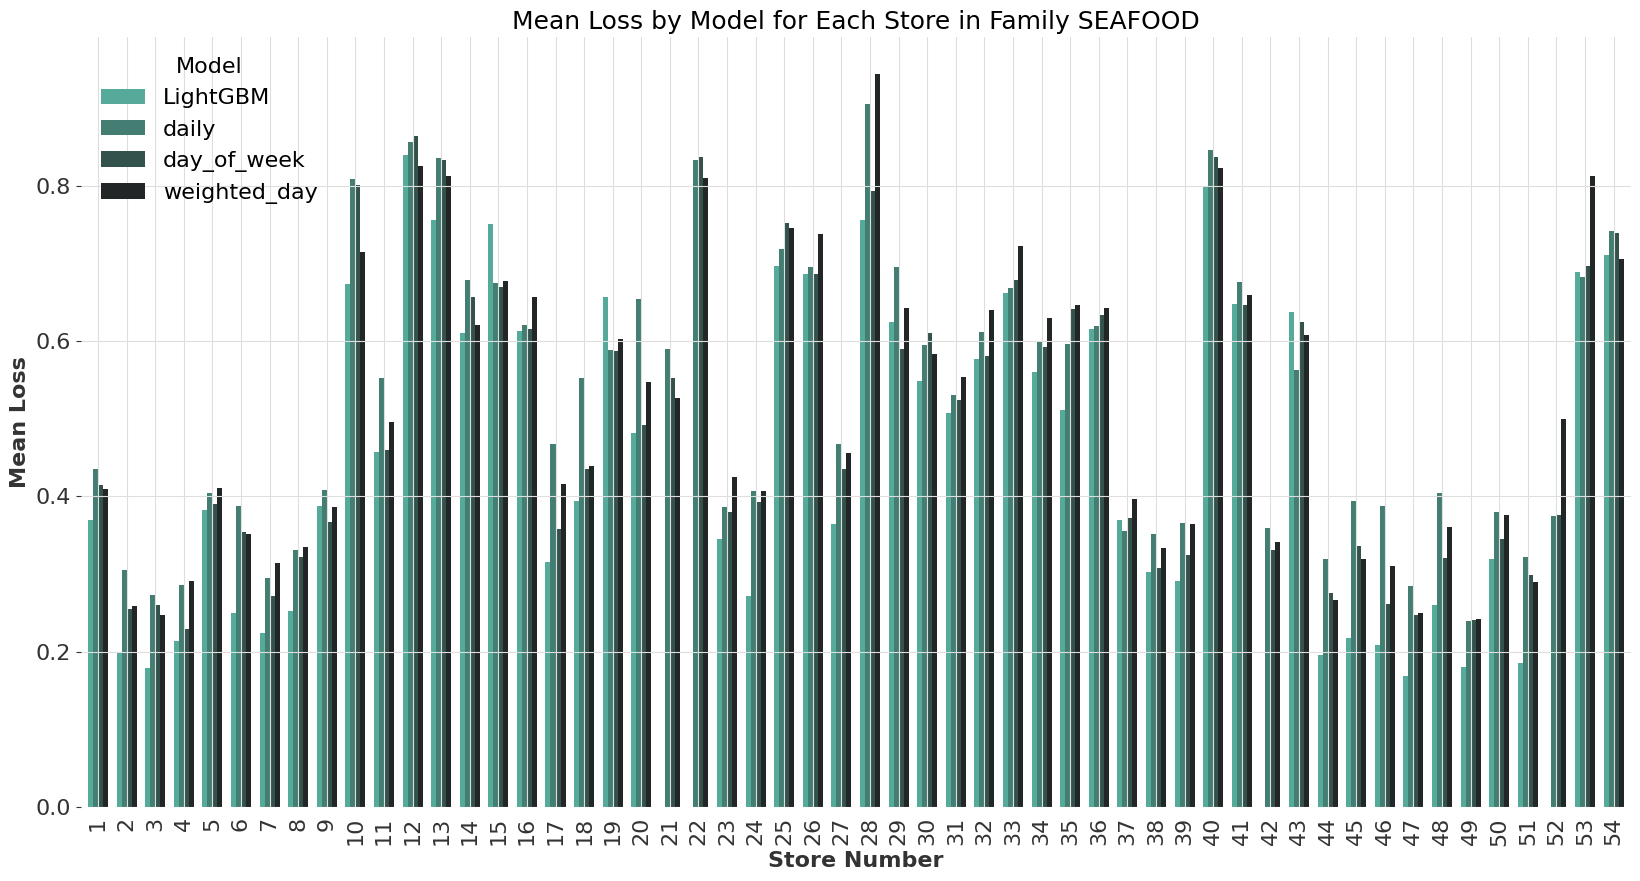

<Figure size 640x480 with 0 Axes>

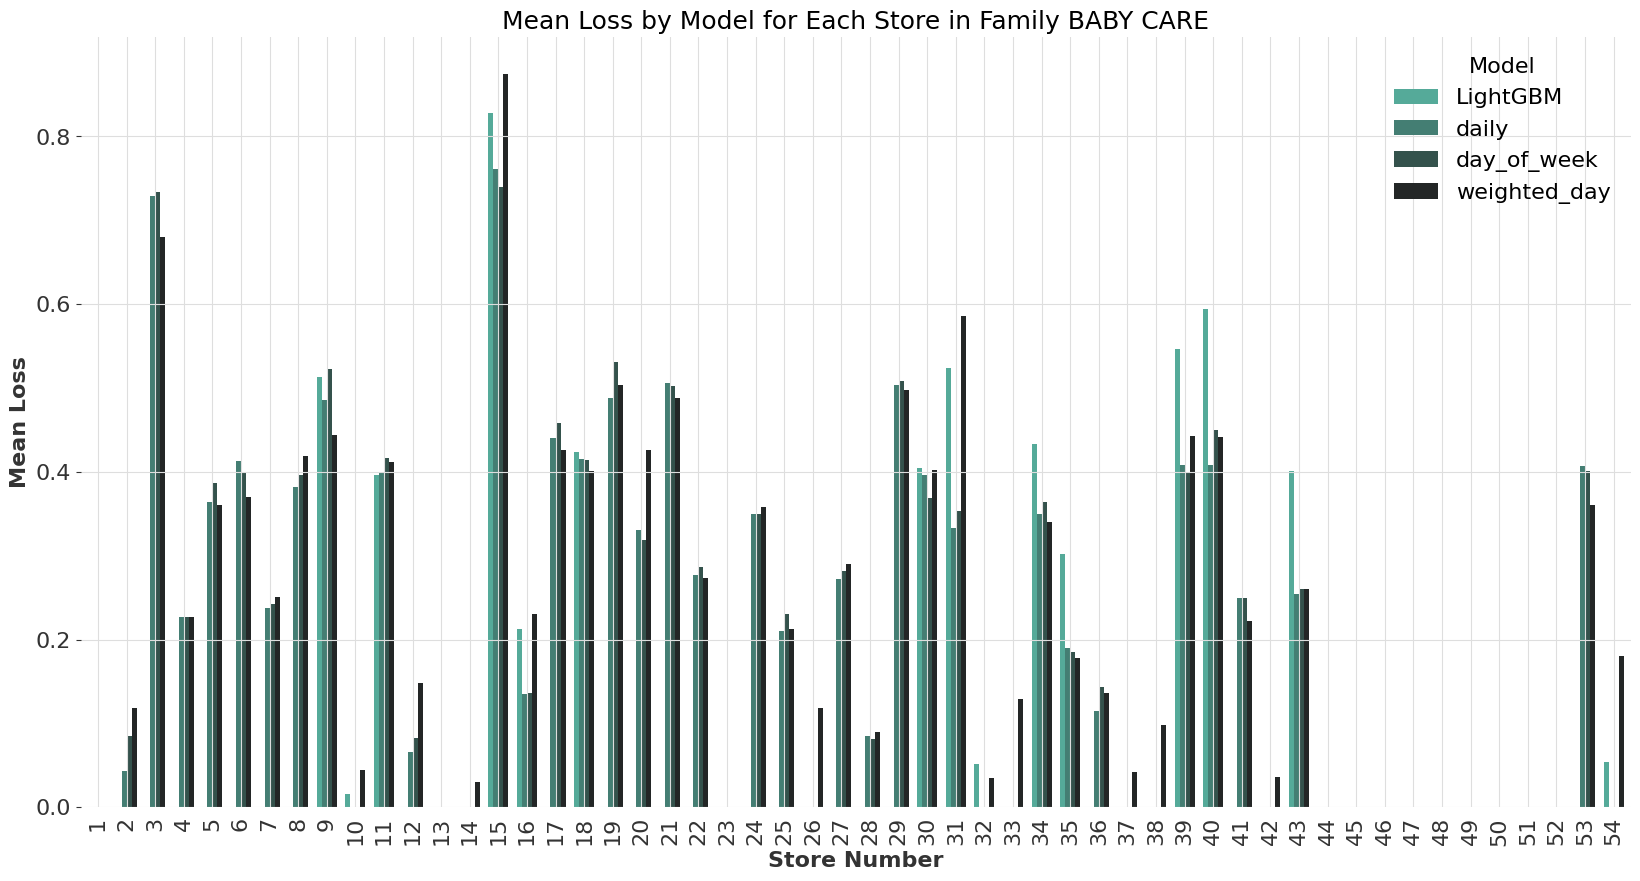

<Figure size 640x480 with 0 Axes>

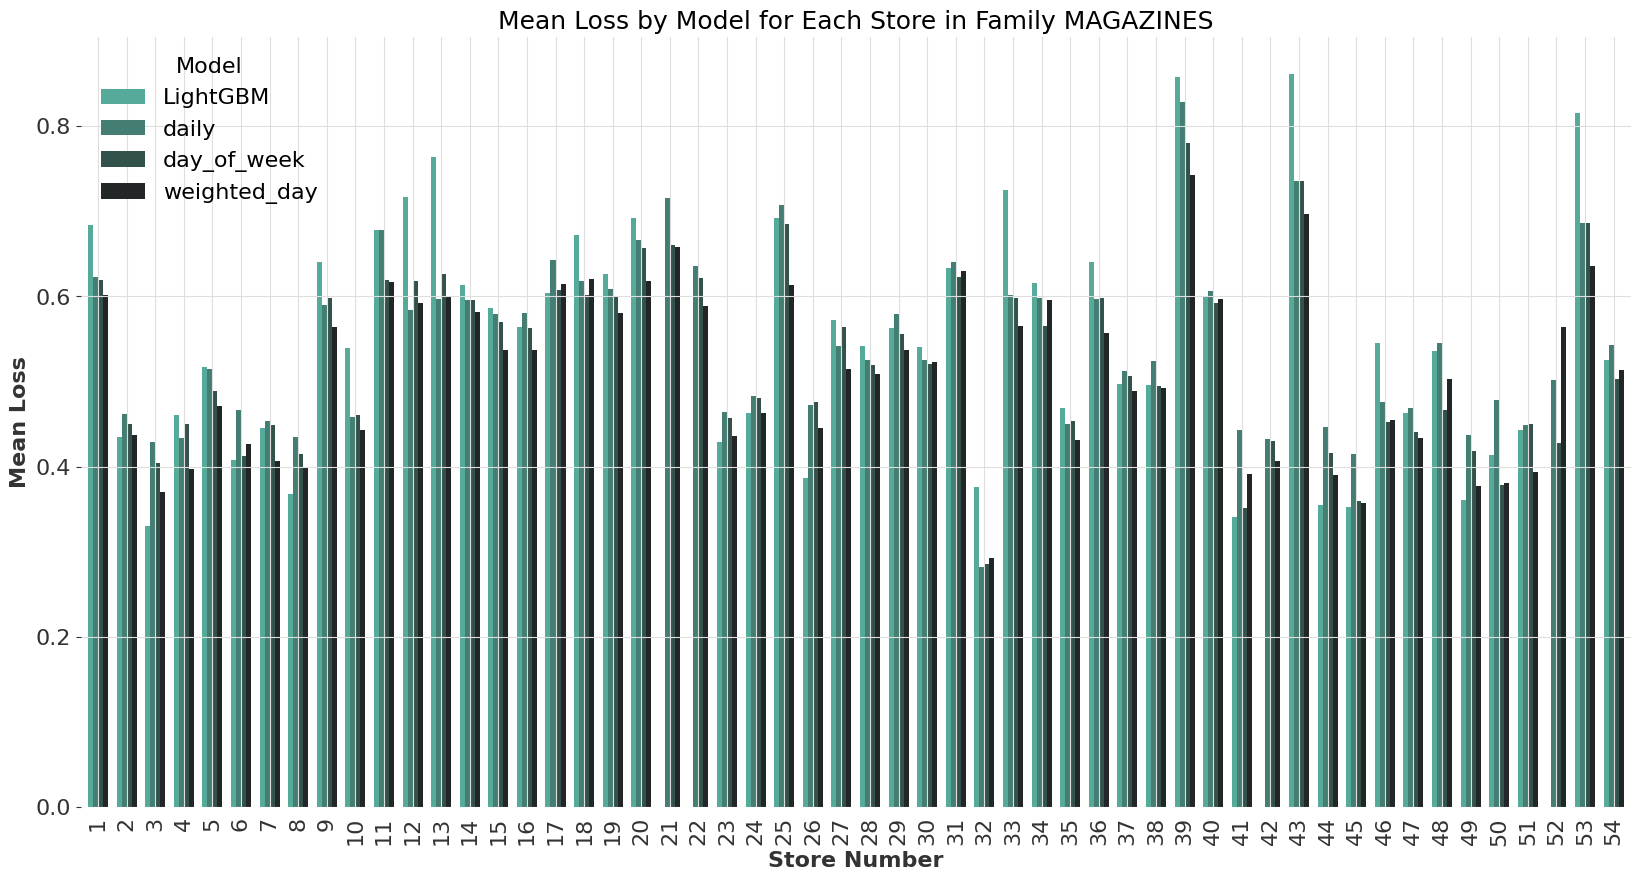

<Figure size 640x480 with 0 Axes>

In [116]:
for family in family_datasets.keys():
    advanced_predictor.make_family_loss_plot(family=family, test_loss=test_period)

## Save Optimal Submission

In [96]:
lightgbm_drop_families = [
    # ---
    "PET SUPPLIES",
    "PLAYERS AND ELECTRONICS",
    "PREPARED FOODS",
    "SEAFOOD",
    "MAGAZINES",
    
    # "PERSONAL CARE",
    # "PRODUCE",
    # "SCHOOL AND OFFICE SUPPLIES",
    
    # "BABY CARE",
]

prediction_df = advanced_predictor.get_optimal_prediction(
    lightgbm_drop_families=lightgbm_drop_families,
)

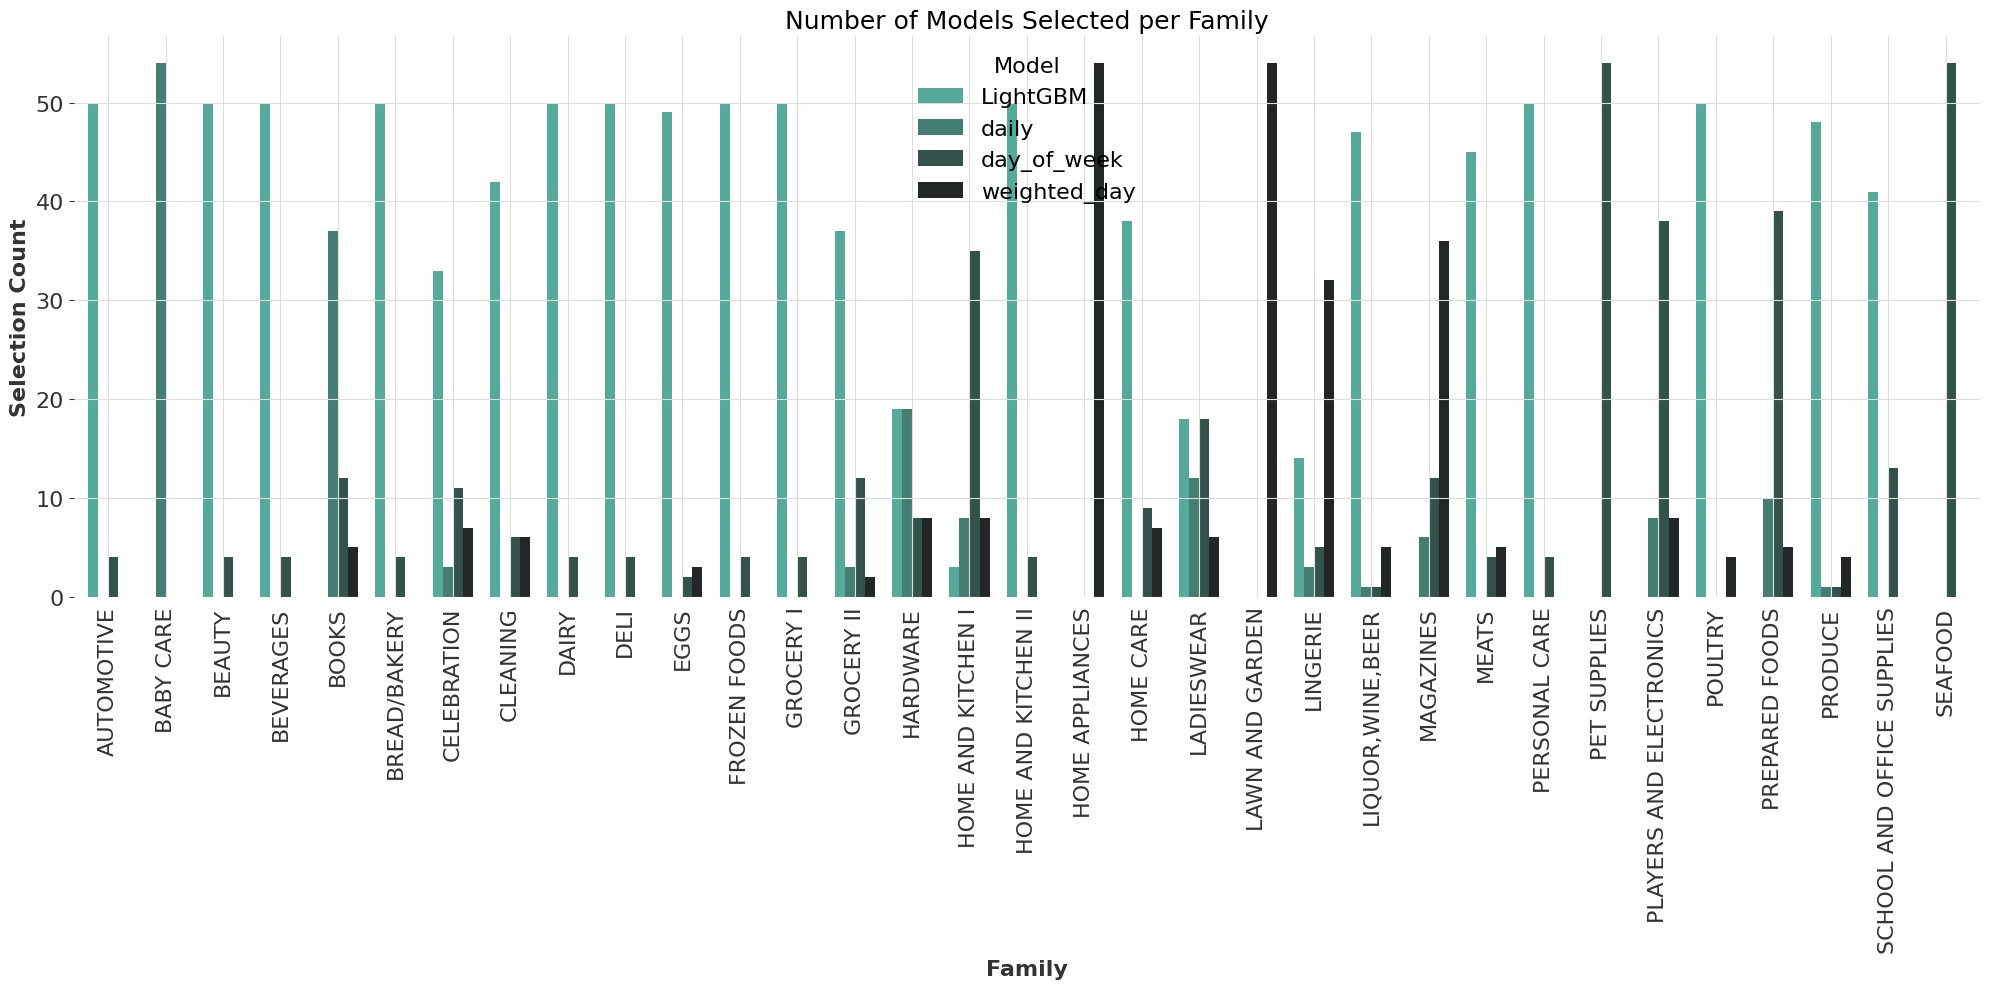

In [97]:
advanced_predictor.make_model_selection_plot()

In [98]:
submission_df = save_submission(
    df=prediction_df,
    file_name="no_specific_families_and_model_selection_strategy_updated.csv",
)

Submission saved to /home/tikhon/PycharmProjects/StoreSales/data/submissions/no_specific_families_and_model_selection_strategy_updated.csv


In [99]:
submission_df.isna().sum()

sales    0
dtype: int64